# INM430 Principles of Data Science Notebook
## Sahan Chowdhury
### Borough-Level Carbon Accountability: A Data-Driven Exploration   of CO2 Emissions in London

#### This notebook contains analysis of carbon emisssions in killotoness of all  London Boroughs in the Domestic, Industrial and Commercial and Transport sector. Specifically looking at the comparison between Domestic and Industrial and Commercial Sector , the comparison between Domestic and Transport sector, the impact of population and population growth on CO2 emissions over time, and predictive analysis of future CO2 emissions

In [905]:
import pandas as pd  
import seaborn as sns  
import matplotlib.pyplot as plt  
import numpy as np  
import geopandas as gpd
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
import warnings
# Ignore warning messages to enhance code readability

# Suppress all warnings to ensure a clean output
warnings.filterwarnings('ignore')



###### Data Preprocessing 

In this section i will clean and process my dataset ready for analysis

In [906]:
#Dataset reference : https://data.london.gov.uk/dataset/leggi
#Reading the data from the CSV File 'emissions.csv' and loading it into a pandas dataframe called data_emissions
data_emissions = pd.read_csv('emissions.csv')
#Displaying the first couple rows and last couple rows of the dataset
print("Where KtCO2e stands for kilotonnes of carbon dioxide equivalent")
data_emissions

Where KtCO2e stands for kilotonnes of carbon dioxide equivalent


Borough  LEGGI_Year    Sector         Fuel Data_Year  \
0     Barking and Dagenham        2017  Domestic  Electricity      2017   
1                   Barnet        2017  Domestic  Electricity      2017   
2                   Bexley        2017  Domestic  Electricity      2017   
3                    Brent        2017  Domestic  Electricity      2017   
4                  Bromley        2017  Domestic  Electricity      2017   
...                    ...         ...       ...          ...       ...   
5035        Waltham Forest        2010     Total        Total       NaN   
5036            Wandsworth        2010     Total        Total       NaN   
5037           Westminster        2010     Total        Total       NaN   
5038         Unapportioned        2010     Total        Total       NaN   
5039                London        2010     Total        Total       NaN   

           KtCO2e  
0     72.53736757  
1     171.5542868  
2       103.10438  
3     117.7367344  
4     151.7814693  
...           ...  
5035   929.465068  
5036  1209.926514  
5037  3212.433061  
5038  67.88765717  
5039  43790.61155  

[5040 rows x 6 columns]

In [907]:
# Check for missing values in the emissions dataset
data_emissions.isnull().sum()

Borough          0
LEGGI_Year       0
Sector           0
Fuel             0
Data_Year     1120
KtCO2e           2
dtype: int64

From the dataframe table, i noticed that the Data_Year and LEGGI_Year is identical, i only require the year of each row,furthermore the Data_Year column has 1120 missing entries so i can remove Data_Year column, as for the 2 missing entries for the KtCO2e column i would need to inspect further

In [908]:
#We want see which rows have a missing value for KtCO2e
data_emissions[data_emissions['KtCO2e'].isnull()]

Borough  LEGGI_Year     Sector      Fuel Data_Year KtCO2e
1048  Unapportioned        2016  Transport  Aviation      2016    NaN
1083  Unapportioned        2016  Transport  Shipping      2016    NaN

We can see that the missing values are from Borough = unapportioned,this will create ambiguity within my analysis hence i can remove all rows which contain unapportioned, this will also remove the 2 missing values under KtCO2e from the dataframe. I will make these changes on another dataframe

In [909]:
data_emissions_copy = data_emissions

In [910]:
#check for duplicate rows
data_emissions_copy[data_emissions_copy.duplicated()]

Empty DataFrame
Columns: [Borough, LEGGI_Year, Sector, Fuel, Data_Year, KtCO2e]
Index: []

In [911]:
#convert nessesary columsn to numeric
data_emissions_copy['LEGGI_Year'] = pd.to_numeric(data_emissions['LEGGI_Year'], errors='coerce')
data_emissions['KtCO2e'] = pd.to_numeric(data_emissions['KtCO2e'], errors='coerce')

In [912]:
#Creating a copy of the original dataset
data_emissions_copy = data_emissions.copy()
#I will alter this copy of the main datafram and perform all data cleaning on this

In [913]:
#Reference = https://stackoverflow.com/questions/13411544/delete-a-column-from-a-pandas-dataframe
#Removing the Data_Year Column, without altering the orignal datafram
data_emissions_copy = data_emissions_copy.drop('Data_Year', axis =1)


In [914]:
#reference: https://www.geeksforgeeks.org/how-to-drop-rows-that-contain-a-specific-string-in-pandas/
#Excluding rows with 'Unapportioned' in the Borough Column
data_emissions_copy = data_emissions_copy[data_emissions_copy["Borough"].str.contains("Unapportioned")==False]
#Display the modified dataframe
data_emissions_copy

Borough  LEGGI_Year    Sector         Fuel        KtCO2e
0     Barking and Dagenham        2017  Domestic  Electricity     72.537368
1                   Barnet        2017  Domestic  Electricity    171.554287
2                   Bexley        2017  Domestic  Electricity    103.104380
3                    Brent        2017  Domestic  Electricity    117.736734
4                  Bromley        2017  Domestic  Electricity    151.781469
...                    ...         ...       ...          ...           ...
5034         Tower Hamlets        2010     Total        Total   2141.889857
5035        Waltham Forest        2010     Total        Total    929.465068
5036            Wandsworth        2010     Total        Total   1209.926514
5037           Westminster        2010     Total        Total   3212.433061
5039                London        2010     Total        Total  43790.611550

[4896 rows x 5 columns]

In conjuction with this dataset i will also use a population dataset 

In [915]:
#Now pre-processing the secondary dataset which will be used in conjuction with this dataset for the project
#Population Dataset
data_population = pd.read_csv('housing-density-borough.csv')

#contains population details for every borough, including square kilometer and population per square kilometer

In [916]:
# Check for missing values in the population dataset
data_population.isnull().sum()
duplicates = data_population.duplicated()



In [917]:
data_population_copy = data_population.copy()




In [918]:
# Remove specified columns
columns_to_remove = ['Code', 'Source', 'Inland_Area _Hectares', 'Total_Area_Hectares', 'Population_per_hectare']
data_population_copy = data_population_copy.drop(columns=columns_to_remove)

# Remove specified rows from the 'Name' column
boroughs_to_remove = ['Inner London', 'London', 'Outer London']
data_population_copy = data_population_copy[~data_population_copy['Name'].isin(boroughs_to_remove)]

# Remove rows for the years 1999 to 2009
years_to_remove_1999_2009 = list(range(1999, 2009))
data_population_copy = data_population_copy[~data_population['Year'].isin(years_to_remove_1999_2009)]

# Remove rows for the years 2040 to 2050
years_to_remove_2040_2050 = list(range(2040, 2051))
data_population_copy = data_population_copy[~data_population_copy['Year'].isin(years_to_remove_2040_2050)]

# Rename columns
data_population_copy = data_population_copy.rename(columns={'Name': 'Borough', 'Year': 'LEGGI_Year'})
data_population_copy


Borough  LEGGI_Year  Population  Square_Kilometres  \
10    City of London        2009        7472                2.9   
11    City of London        2010        7338                2.9   
12    City of London        2011        7412                2.9   
13    City of London        2012        7204                2.9   
14    City of London        2013        6848                2.9   
...              ...         ...         ...                ...   
1752  Greater London        2035    10396960             1572.1   
1753  Greater London        2036    10464787             1572.1   
1754  Greater London        2037    10531109             1572.1   
1755  Greater London        2038    10596112             1572.1   
1756  Greater London        2039    10659260             1572.1   

      Population_per_square_kilometre  
10                             2573.1  
11                             2526.9  
12                             2552.4  
13                             2480.8  
14                             2358.2  
...                               ...  
1752                           6613.2  
1753                           6656.4  
1754                           6698.6  
1755                           6739.9  
1756                           6780.1  

[1052 rows x 5 columns]

In [919]:
print("Population")
print(data_population_copy['Borough'].unique())


print("Emissions")

print(data_emissions_copy['Borough'].unique())
# Replace 'Richmond' with 'Richmond upon Thames' in both dataframes
data_emissions_copy['Borough'] = data_emissions_copy['Borough'].replace('Richmond', 'Richmond upon Thames')


# Replace 'Kingston' with 'Kingston upon Thames' in both dataframes
data_emissions_copy['Borough'] = data_emissions_copy['Borough'].replace('Kingston', 'Kingston upon Thames')


# Replace 'Greater London' with 'London' in the population dataframe
data_population_copy['Borough'] = data_population_copy['Borough'].replace('Greater London', 'London')

data_emissions_population = pd.merge(data_emissions_copy, data_population_copy, on=['Borough', 'LEGGI_Year'], how='inner')



Population
['City of London' 'Barking and Dagenham' 'Barnet' 'Bexley' 'Brent'
 'Bromley' 'Camden' 'Croydon' 'Ealing' 'Enfield' 'Greenwich' 'Hackney'
 'Hammersmith and Fulham' 'Haringey' 'Harrow' 'Havering' 'Hillingdon'
 'Hounslow' 'Islington' 'Kensington and Chelsea' 'Kingston upon Thames'
 'Lambeth' 'Lewisham' 'Merton' 'Newham' 'Redbridge' 'Richmond upon Thames'
 'Southwark' 'Sutton' 'Tower Hamlets' 'Waltham Forest' 'Wandsworth'
 'Westminster' 'Greater London']
Emissions
['Barking and Dagenham' 'Barnet' 'Bexley' 'Brent' 'Bromley' 'Camden'
 'City of London' 'Croydon' 'Ealing' 'Enfield' 'Greenwich' 'Hackney'
 'Hammersmith and Fulham' 'Haringey' 'Harrow' 'Havering' 'Hillingdon'
 'Hounslow' 'Islington' 'Kensington and Chelsea' 'Kingston' 'Lambeth'
 'Lewisham' 'Merton' 'Newham' 'Redbridge' 'Richmond' 'Southwark' 'Sutton'
 'Tower Hamlets' 'Waltham Forest' 'Wandsworth' 'Westminster' 'London']


In [920]:
# Create the 'Emissions_per_Capita' column
data_emissions_population['Emissions_per_Capita'] = data_emissions_population['KtCO2e'] / data_emissions_population['Population']


# Save the DataFrame to a CSV file
data_emissions_population.to_csv('data_emissions_population_.csv', index=False)
data_emissions_population

Borough  LEGGI_Year     Sector               Fuel  \
0     Barking and Dagenham        2017   Domestic        Electricity   
1     Barking and Dagenham        2017   Domestic                Gas   
2     Barking and Dagenham        2017   Domestic               Coal   
3     Barking and Dagenham        2017   Domestic                Oil   
4     Barking and Dagenham        2017   Domestic              Total   
...                    ...         ...        ...                ...   
4873           Westminster        2010  Transport    Railways diesel   
4874           Westminster        2010  Transport  Railways electric   
4875           Westminster        2010  Transport     Road Transport   
4876           Westminster        2010  Transport              Total   
4877           Westminster        2010      Total              Total   

           KtCO2e  Population  Square_Kilometres  \
0       72.537368      210513               36.1   
1      144.862242      210513               36.1   
2        1.931094      210513               36.1   
3        0.654757      210513               36.1   
4      219.985461      210513               36.1   
...           ...         ...                ...   
4873     3.634070      217187               21.5   
4874    64.715012      217187               21.5   
4875   258.608611      217187               21.5   
4876   327.135007      217187               21.5   
4877  3212.433061      217187               21.5   

      Population_per_square_kilometre  Emissions_per_Capita  
0                              5830.1              0.000345  
1                              5830.1              0.000688  
2                              5830.1              0.000009  
3                              5830.1              0.000003  
4                              5830.1              0.001045  
...                               ...                   ...  
4873                          10107.8              0.000017  
4874                          10107.8              0.000298  
4875                          10107.8              0.001191  
4876                          10107.8              0.001506  
4877                          10107.8              0.014791  

[4878 rows x 9 columns]

In [921]:
data_emissions_population.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4878 entries, 0 to 4877
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Borough                          4878 non-null   object 
 1   LEGGI_Year                       4878 non-null   int64  
 2   Sector                           4878 non-null   object 
 3   Fuel                             4878 non-null   object 
 4   KtCO2e                           4878 non-null   float64
 5   Population                       4878 non-null   int64  
 6   Square_Kilometres                4878 non-null   float64
 7   Population_per_square_kilometre  4878 non-null   float64
 8   Emissions_per_Capita             4878 non-null   float64
dtypes: float64(4), int64(2), object(3)
memory usage: 343.1+ KB


##### Interpreting the data

In [922]:
# Displaying all Boroughs in the DataFrame
boroughs = (data_emissions_population['Borough'].unique())
#Displaying number of Boroughs
##Reference : https://stackoverflow.com/questions/45759966/counting-unique-values-in-a-column-in-pandas-dataframe-like-in-qlik
print('Number of Boroughs including London is',data_emissions_copy['Borough'].nunique())
boroughs

Number of Boroughs including London is 34


array(['Barking and Dagenham', 'Barnet', 'Bexley', 'Brent', 'Bromley',
       'Camden', 'City of London', 'Croydon', 'Ealing', 'Enfield',
       'Greenwich', 'Hackney', 'Hammersmith and Fulham', 'Haringey',
       'Harrow', 'Havering', 'Hillingdon', 'Hounslow', 'Islington',
       'Kensington and Chelsea', 'Kingston upon Thames', 'Lambeth',
       'Lewisham', 'Merton', 'Newham', 'Redbridge',
       'Richmond upon Thames', 'Southwark', 'Sutton', 'Tower Hamlets',
       'Waltham Forest', 'Wandsworth', 'Westminster', 'London'],
      dtype=object)

I will also be using a shapefile of map of London and borough boundaries i need to ensure that the borough names in the shapefile match with that of my dataset

In [923]:
# Print unique borough names in map_df
# Load the shapefile
map_df = gpd.read_file('statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp')

#Printing the unique borough names in the shapefile
print("Unique Borough Names in map_df:")
print(map_df['NAME'].unique())

Unique Borough Names in map_df:
['Kingston upon Thames' 'Croydon' 'Bromley' 'Hounslow' 'Ealing' 'Havering'
 'Hillingdon' 'Harrow' 'Brent' 'Barnet' 'Lambeth' 'Southwark' 'Lewisham'
 'Greenwich' 'Bexley' 'Enfield' 'Waltham Forest' 'Redbridge' 'Sutton'
 'Richmond upon Thames' 'Merton' 'Wandsworth' 'Hammersmith and Fulham'
 'Kensington and Chelsea' 'Westminster' 'Camden' 'Tower Hamlets'
 'Islington' 'Hackney' 'Haringey' 'Newham' 'Barking and Dagenham'
 'City of London']


The boroughs names which are different are 'Kingston upon Thames' and 'Richmond upon Thames', i will update these on my dataframe

In [924]:
# Update specific borough names on our dataset to match that off the shapefile
data_emissions_population['Borough'] = data_emissions_population['Borough'].replace({'Kingston': 'Kingston upon Thames', 'Richmond': 'Richmond upon Thames'})

# Verify the changes
print("\nUnique Borough Names in data_emissions_copy after update:")
print(data_emissions_copy['Borough'].unique())



Unique Borough Names in data_emissions_copy after update:
['Barking and Dagenham' 'Barnet' 'Bexley' 'Brent' 'Bromley' 'Camden'
 'City of London' 'Croydon' 'Ealing' 'Enfield' 'Greenwich' 'Hackney'
 'Hammersmith and Fulham' 'Haringey' 'Harrow' 'Havering' 'Hillingdon'
 'Hounslow' 'Islington' 'Kensington and Chelsea' 'Kingston upon Thames'
 'Lambeth' 'Lewisham' 'Merton' 'Newham' 'Redbridge' 'Richmond upon Thames'
 'Southwark' 'Sutton' 'Tower Hamlets' 'Waltham Forest' 'Wandsworth'
 'Westminster' 'London']


In [925]:
# Displaying the unique sectors and corresponding fuels in the DataFrame
for sector, fuel_types in data_emissions_copy.groupby('Sector')['Fuel']:
    print(f"{sector} Sector: {fuel_types.unique()}")



Domestic Sector: ['Electricity' 'Gas' 'Coal' 'Oil' 'Total']
Industrial and Commercial Sector: ['Electricity w/o rail' 'Gas' 'Coal' 'Oil' 'Waste and Renewables' 'Total']
Total Sector: ['Total']
Transport Sector: ['Aviation' 'Shipping' 'Railways diesel' 'Railways electric'
 'Road Transport' 'Total']


###### Data Visualization

Part 1 General data oversight

Pearson Correlation: -0.40, p-value: 0.0760


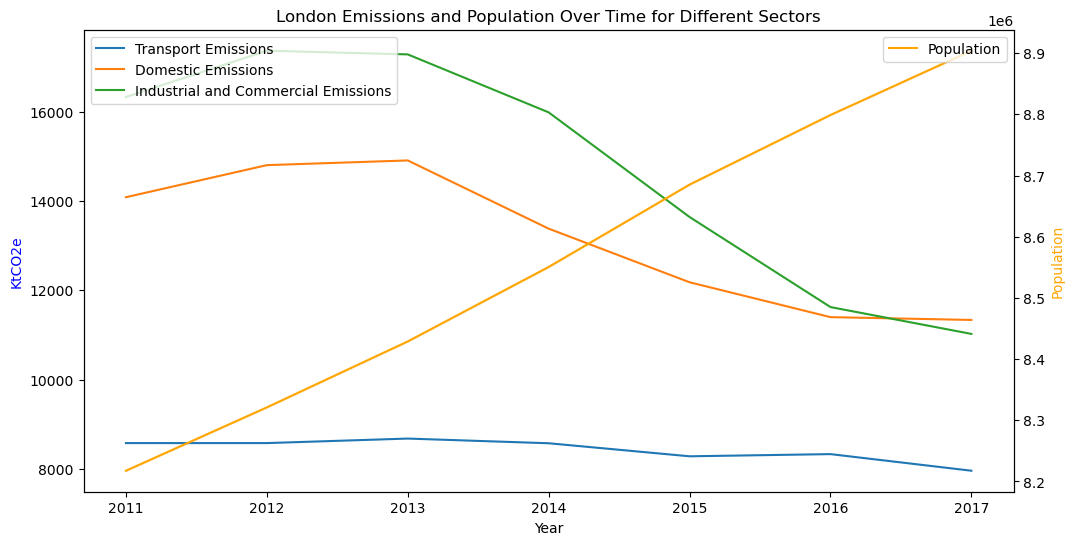

In [926]:
#Plotting a line graph showing trend of total sectors co2 emissions for London every year
# Filter data for Borough = London, Fuel = Total, and specific sectors
# Filtering data for London, specific sectors, Total fuel, and years between 2010 and 2017
filtered_data_london_sectors_2010_2017 = data_emissions_population[ (data_emissions_population['Borough'] == 'London') &  (data_emissions_population['Sector'].isin(['Transport', 'Domestic', 'Industrial and Commercial'])) &(data_emissions_population['Fuel'] =='Total') & (data_emissions_population['LEGGI_Year'].between(2010, 2017))]

#Reference: https://stackoverflow.com/questions/20288842/matplotlib-iterate-subplot-axis-array-through-single-list
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting line graphs for the different sectors
for sector in ['Transport', 'Domestic', 'Industrial and Commercial']:
    sns.lineplot(x='LEGGI_Year', y='KtCO2e', data=filtered_data_london_sectors_2010_2017[filtered_data_london_sectors_2010_2017['Sector'] == sector], label=f'{sector} Emissions', ax=ax1)

# Create a second y-axis to plot population data
ax2 = ax1.twinx()
sns.lineplot(x='LEGGI_Year', y='Population', data=filtered_data_london_sectors_2010_2017, label='Population', color='orange', ax=ax2)

ax1.set_title('London Emissions and Population Over Time for Different Sectors')
ax1.set_xlabel('Year')
ax1.set_ylabel('KtCO2e', color='blue')
ax2.set_ylabel('Population', color='orange')

# Display the legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Calculate Pearson correlation only if lengths match
correlation, p_value = pearsonr(filtered_data_london_sectors_2010_2017['KtCO2e'].dropna(), filtered_data_london_sectors_2010_2017['Population'].dropna())
print(f"Pearson Correlation: {correlation:.2f}, p-value: {p_value:.4f}")

plt.show()


Graph 1: Overall we can see that overtime the amount of KtCO2e has gradually decreased for every sector. Domestic and Industrial and commercial were far greater in 2010 than transport however end of 2017 we can see the gap between these sectors has closed down. Furthermore both Domestic and industrial and commericial had a greater decrease, however during 2011 it increased again. The transport sector seems to have stay constant throughout, and we can see during 2016 industrial and commercial fell below Domestic. Since this data gives a general overview i now want to inspect further for every sector and find any extremes. Since my dataset cant have outliers but extremes i want to find extremes and do analysis on it.

Part 2 Detecting extremes

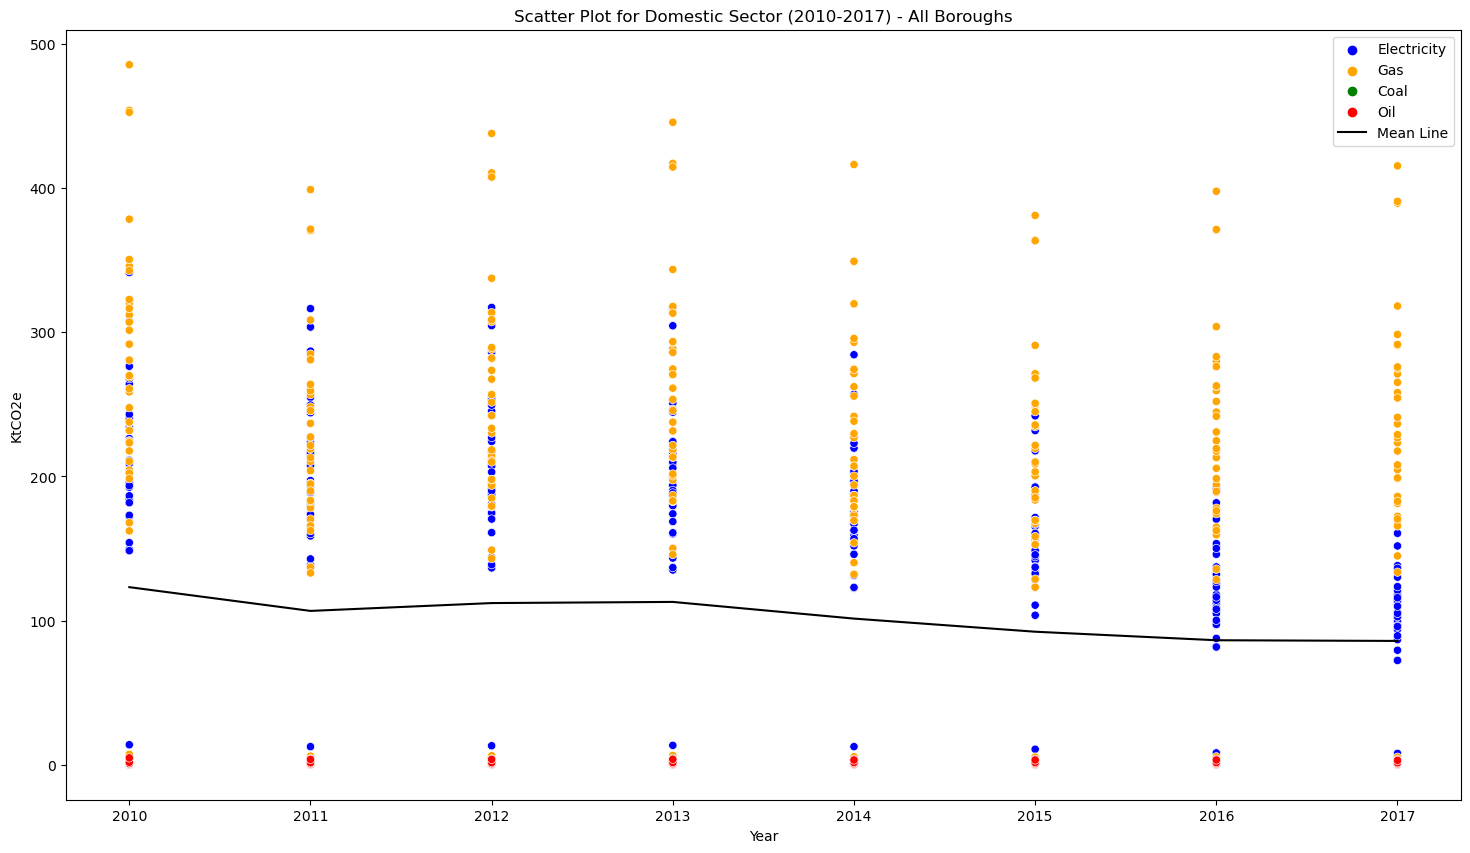

In [927]:
#Plotting for Domestic Sector (2010-2017) - All Boroughs
# Filter data for the relevant years and exclude London borough and 'Total' fuel type
filtered_data_domestic_boroughs_Nottotal = data_emissions_copy[(data_emissions_copy['Borough'] != 'London') &(data_emissions_copy['Fuel'].isin(['Electricity', 'Gas', 'Coal', 'Oil'])) &(data_emissions_copy['Sector'] == 'Domestic')]
filtered_data_domestic_boroughs_Nottotal['KtCO2e'] = pd.to_numeric(filtered_data_domestic_boroughs_Nottotal['KtCO2e'], errors='coerce')

# Plot scatter plot for the 'Domestic' sector
plt.figure(figsize=(18, 10))
sns.scatterplot(x='LEGGI_Year', y='KtCO2e',hue='Fuel', data=filtered_data_domestic_boroughs_Nottotal, palette={'Electricity': 'blue', 'Gas': 'orange', 'Coal': 'green', 'Oil': 'red'})
                
# Calculate mean values for each year
mean_line = filtered_data_domestic_boroughs_Nottotal.groupby('LEGGI_Year')['KtCO2e'].mean().reset_index()

# Plot mean line for the entire graph
sns.lineplot(legend = True, x='LEGGI_Year', y='KtCO2e', data=mean_line, color='black', label='Mean Line')


plt.title('Scatter Plot for Domestic Sector (2010-2017) - All Boroughs')
plt.xlabel('Year')
plt.ylabel('KtCO2e')
plt.show()

From the scatter plot we can observe that majority of domestic CO2 emissions are very closely packed. Overall we see that the maximum value has lowered over the years from 485 to 415 KTCO2e and the means is also falling. Since we cannot have outliers as there is no specific trend with the data i will pick out which plots are away from the pack and do specific analysis. Another observation we can make is that majority of the plots higher up comes from Gas, followed by electricity, hence we can say that most fuel type which accounts for domestic carbon emission in london boroughs is Gas and Electricity. The lower threshold of 7% represents the 7th percentile of the z-scores distribution. This threshold is set relatively low to identify data points that are significantly below the mean. The upper threshold of 98% represents the 98th percentile of the z-scores distribution. This threshold is set relatively high to identify data points that are significantly above the mean. Choosing percentiles allows for a more flexible and data-driven approach to identify outliers, capturing extreme values while minimizing the impact of mild fluctuations in the data.Since we wanted to identify the boroughs which do not follow the majority we used percentile to obtain. On the lower end there was a variation of boroughs for fuel types coal and oil, and City of london was the only borough which seemed to have repeatedly very low emissions of coal throughout. However on the other end of Barney, Bromley and Croydon whom seemed have the higest domestic fuel consumption from 2010 to 2017 , and it was all Gas.


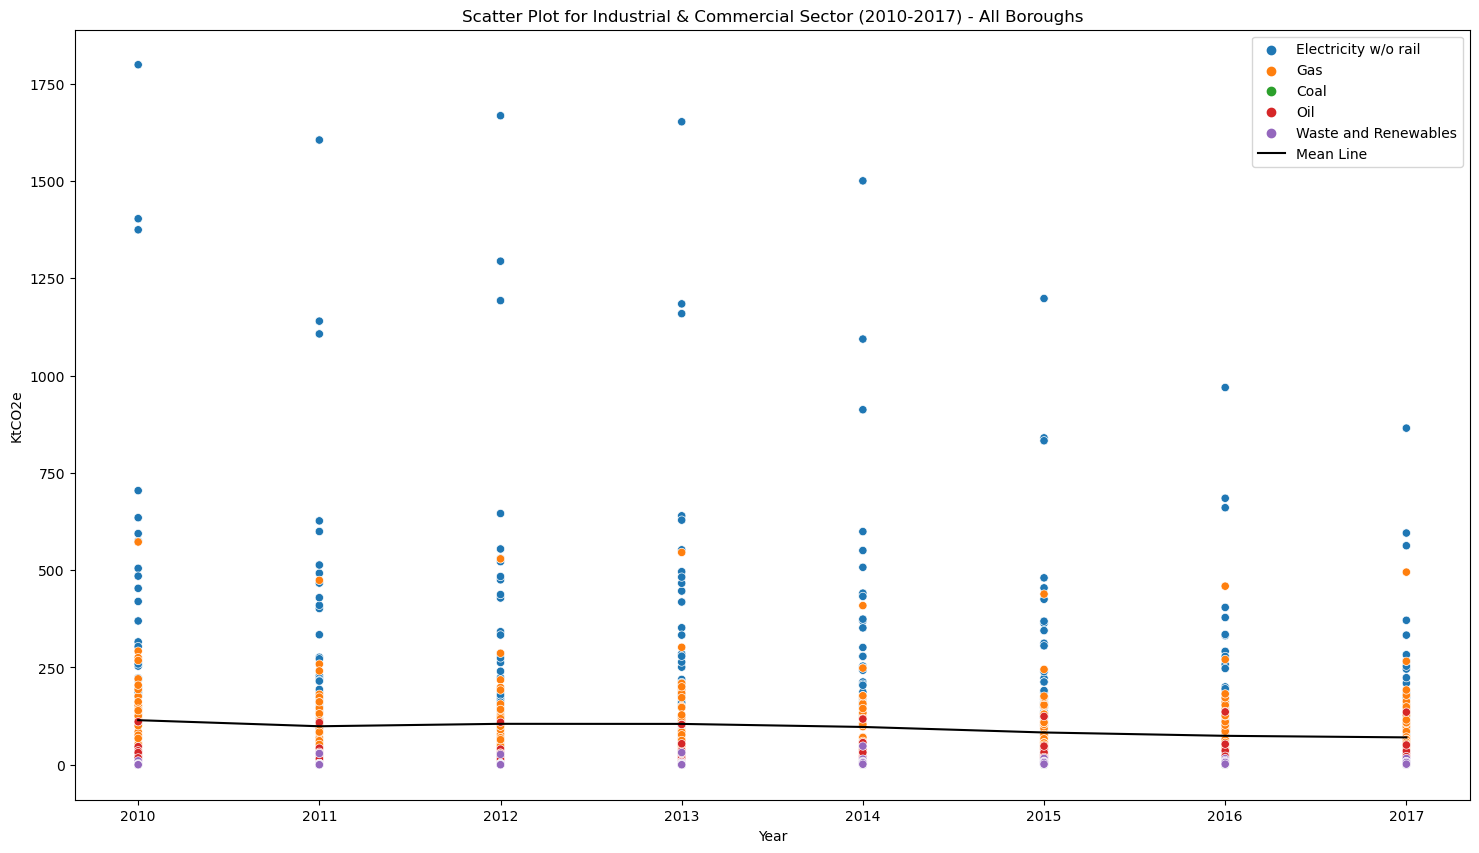

In [928]:
#Plotting for Domestic Sector (2010-2017) - All Boroughs
# Filter data for the relevant years and exclude London borough and 'Total' fuel type - setting conditions
filtered_data_industrial_commercial_boroughs_Nottotal = data_emissions_copy[(data_emissions_copy['Borough'] != 'London') &(data_emissions_copy['Fuel'].isin(['Electricity w/o rail', 'Gas', 'Coal', 'Oil', 'Waste and Renewables'])) &(data_emissions_copy['Sector'] == 'Industrial and Commercial')]
filtered_data_industrial_commercial_boroughs_Nottotal['KtCO2e'] = pd.to_numeric(filtered_data_industrial_commercial_boroughs_Nottotal['KtCO2e'], errors='coerce')
# Plot scatter plot for the 'Domestic' sector
plt.figure(figsize=(18, 10))
sns.scatterplot(x='LEGGI_Year', y='KtCO2e',hue='Fuel', data=filtered_data_industrial_commercial_boroughs_Nottotal)
                
# Calculate mean values for each year
mean_line = filtered_data_industrial_commercial_boroughs_Nottotal.groupby('LEGGI_Year')['KtCO2e'].mean().reset_index()

# Plot mean line for the entire graph
sns.lineplot(legend = True, x='LEGGI_Year', y='KtCO2e', data=mean_line, color='black', label='Mean Line')

# Set plot title and axis labels
plt.title('Scatter Plot for Industrial & Commercial Sector (2010-2017) - All Boroughs')
plt.xlabel('Year')
plt.ylabel('KtCO2e')
plt.show()

In [929]:
# calculating z score to detect extremes
# Reference: https://www.geeksforgeeks.org/z-score-for-outlier-detection-python/
# Function to calculate z-scores
def z_score(data):
    return (data - np.mean(data)) / np.std(data)
   

# Calculate z-scores for each data point within its group (year)
filtered_data_industrial_commercial_boroughs_Nottotal['Z_Score'] = filtered_data_industrial_commercial_boroughs_Nottotal.groupby('LEGGI_Year')['KtCO2e'].transform(z_score)


# Set a threshold for z-score to identify outliers
z_score_threshold = 3  
   

# Identify outliers based on z-score
print("Extremes for Industrial and Commercial Sector:")
outliers_industrial_commercial = (filtered_data_industrial_commercial_boroughs_Nottotal[np.abs(filtered_data_industrial_commercial_boroughs_Nottotal['Z_Score']) > z_score_threshold])

outliers_industrial_commercial
# Print or analyze the outlier data



Extremes for Industrial and Commercial Sector:


Borough  LEGGI_Year                     Sector  \
181   City of London        2017  Industrial and Commercial   
204    Tower Hamlets        2017  Industrial and Commercial   
207      Westminster        2017  Industrial and Commercial   
242      Westminster        2017  Industrial and Commercial   
811   City of London        2016  Industrial and Commercial   
834    Tower Hamlets        2016  Industrial and Commercial   
837      Westminster        2016  Industrial and Commercial   
1441  City of London        2015  Industrial and Commercial   
1464   Tower Hamlets        2015  Industrial and Commercial   
1467     Westminster        2015  Industrial and Commercial   
2071  City of London        2014  Industrial and Commercial   
2094   Tower Hamlets        2014  Industrial and Commercial   
2097     Westminster        2014  Industrial and Commercial   
2701  City of London        2013  Industrial and Commercial   
2724   Tower Hamlets        2013  Industrial and Commercial   
2727     Westminster        2013  Industrial and Commercial   
3331  City of London        2012  Industrial and Commercial   
3354   Tower Hamlets        2012  Industrial and Commercial   
3357     Westminster        2012  Industrial and Commercial   
3961  City of London        2011  Industrial and Commercial   
3984   Tower Hamlets        2011  Industrial and Commercial   
3987     Westminster        2011  Industrial and Commercial   
4591  City of London        2010  Industrial and Commercial   
4614   Tower Hamlets        2010  Industrial and Commercial   
4617     Westminster        2010  Industrial and Commercial   

                      Fuel       KtCO2e   Z_Score  
181   Electricity w/o rail   562.696025  4.156748  
204   Electricity w/o rail   595.265801  4.431665  
207   Electricity w/o rail   864.793818  6.706713  
242                    Gas   494.822970  3.583841  
811   Electricity w/o rail   660.330347  4.486347  
834   Electricity w/o rail   684.601023  4.672134  
837   Electricity w/o rail   969.152924  6.850320  
1441  Electricity w/o rail   839.742224  4.831071  
1464  Electricity w/o rail   832.361598  4.783963  
1467  Electricity w/o rail  1197.811216  7.116504  
2071  Electricity w/o rail   912.075197  4.254512  
2094  Electricity w/o rail  1093.616797  5.202183  
2097  Electricity w/o rail  1500.096514  7.324061  
2701  Electricity w/o rail  1184.064963  5.005738  
2724  Electricity w/o rail  1158.908821  4.889055  
2727  Electricity w/o rail  1651.911933  7.175795  
3331  Electricity w/o rail  1192.370394  4.956002  
3354  Electricity w/o rail  1293.683110  5.417794  
3357  Electricity w/o rail  1667.507353  7.121714  
3961  Electricity w/o rail  1139.671720  5.053522  
3984  Electricity w/o rail  1106.843914  4.894136  
3987  Electricity w/o rail  1605.052862  7.313044  
4591  Electricity w/o rail  1374.345398  5.257806  
4614  Electricity w/o rail  1402.830505  5.376679  
4617  Electricity w/o rail  1798.474398  7.027769

From this plot we observe that for the industrial and commericial sector, majority of the points are blue suggesting the higest fuel consumption in this sector is Electricity w/o rail. Majority of the plots lie between 0 and 750 KTCO2e. The maximum value has significantly dropped from 1798 KTCO2e in 2010 to 864 KTCO2e in 2010. The mean has also decreased. When we use z score to calculate outliers we see westminister, towerhamlets and city of london dominate the timestamp with electricity w/o rail, altough there has been a huge decrease since 2010, these 3 borough are still leading CO2 emissions for the industrial and commericial sector in 2017

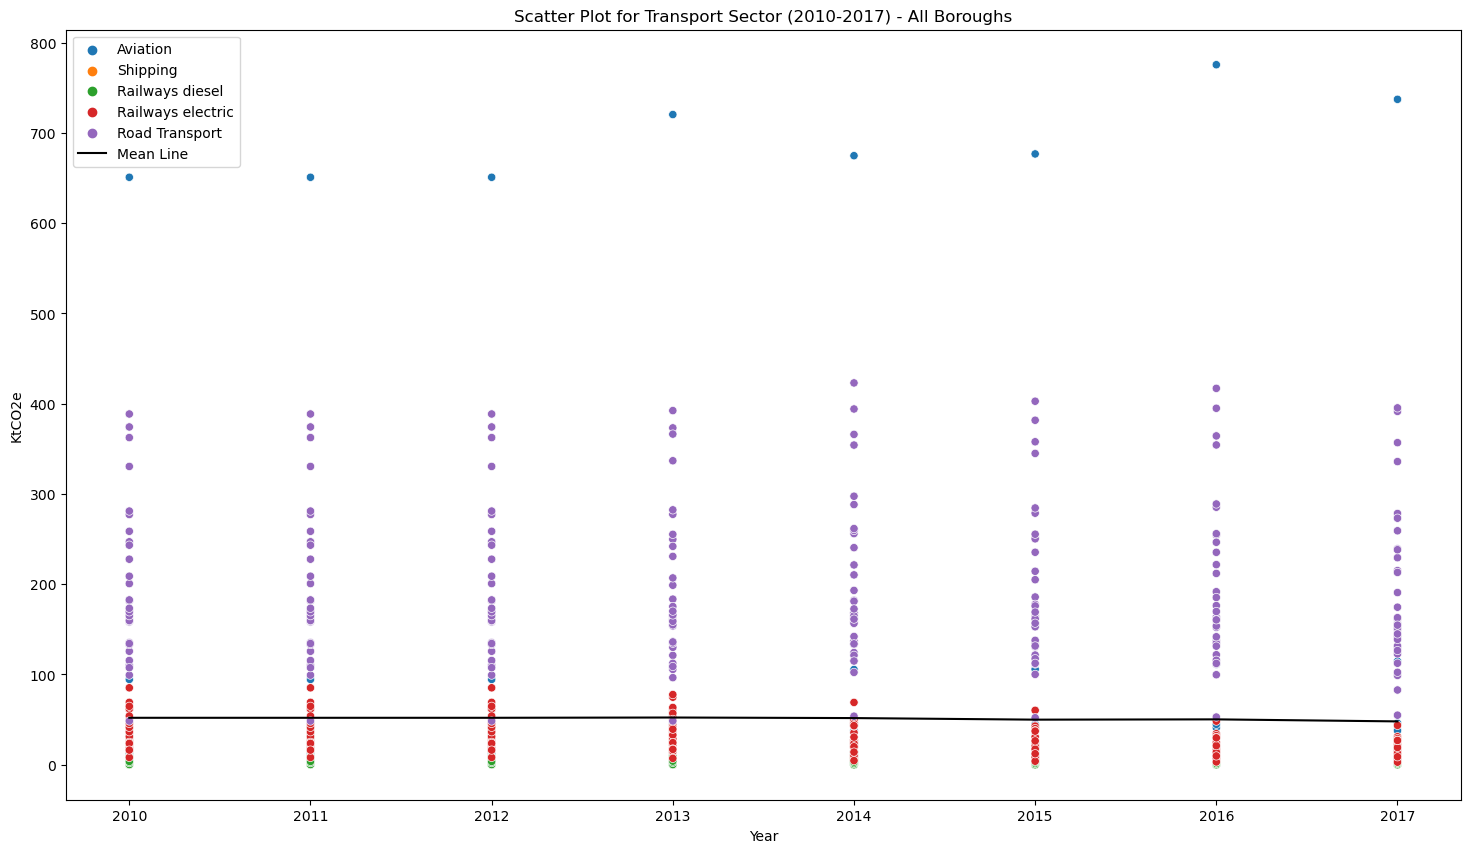

In [930]:
#Plotting for Transport Sector (2010-2017) - All Boroughs
# Filter data for the relevant years and exclude London borough and 'Total' fuel type
filtered_data_transport_boroughs_Nottotal = data_emissions_copy[    (data_emissions_copy['Borough'] != 'London') &(data_emissions_copy['Fuel'].isin(['Aviation', 'Shipping', 'Railways diesel', 'Railways electric', 'Road Transport'])) &(data_emissions_copy['Sector'] == 'Transport')]
filtered_data_transport_boroughs_Nottotal['KtCO2e'] = pd.to_numeric(filtered_data_transport_boroughs_Nottotal['KtCO2e'], errors='coerce')
# Plot scatter plot for the 'Domestic' sector
plt.figure(figsize=(18, 10))
sns.scatterplot(x='LEGGI_Year', y='KtCO2e',hue='Fuel', data=filtered_data_transport_boroughs_Nottotal)
                
# Calculate mean values for each year
mean_line = filtered_data_transport_boroughs_Nottotal.groupby('LEGGI_Year')['KtCO2e'].mean().reset_index()

# Plot mean line for the entire graph
sns.lineplot(legend = True, x='LEGGI_Year', y='KtCO2e', data=mean_line, color='black', label='Mean Line')

# Set plot title and axis labels
plt.title('Scatter Plot for Transport Sector (2010-2017) - All Boroughs')
plt.xlabel('Year')
plt.ylabel('KtCO2e')
plt.show()

In [931]:
#Reference: https://www.geeksforgeeks.org/z-score-for-outlier-detection-python/

# Function to calculate z-scores
def z_score(data):
    return (data - np.mean(data)) / np.std(data)

# Calculate z-scores for each data point within its group (year)
filtered_data_transport_boroughs_Nottotal['Z_Score'] = filtered_data_transport_boroughs_Nottotal.groupby('LEGGI_Year')['KtCO2e'].transform(z_score)

# Set a threshold for z-score to identify outliers
z_score_threshold = 3 


outliers_transport = filtered_data_transport_boroughs_Nottotal[np.abs(filtered_data_transport_boroughs_Nottotal['Z_Score']) > z_score_threshold]


outliers_transport

Borough  LEGGI_Year     Sector            Fuel      KtCO2e   Z_Score
401   Hillingdon        2017  Transport        Aviation  737.184352  6.952556
526       Barnet        2017  Transport  Road Transport  391.447763  3.464719
534      Enfield        2017  Transport  Road Transport  356.818276  3.115372
541   Hillingdon        2017  Transport  Road Transport  395.341681  3.504001
1031  Hillingdon        2016  Transport        Aviation  775.528162  7.025809
1156      Barnet        2016  Transport  Road Transport  394.905080  3.338701
1164     Enfield        2016  Transport  Road Transport  364.302792  3.042256
1171  Hillingdon        2016  Transport  Road Transport  416.970145  3.552446
1661  Hillingdon        2015  Transport        Aviation  676.695013  6.419062
1786      Barnet        2015  Transport  Road Transport  381.642066  3.397251
1794     Enfield        2015  Transport  Road Transport  357.794406  3.153013
1800    Havering        2015  Transport  Road Transport  344.898387  3.020937
1801  Hillingdon        2015  Transport  Road Transport  402.714136  3.613063
2291  Hillingdon        2014  Transport        Aviation  674.745207  6.248054
2416      Barnet        2014  Transport  Road Transport  394.127266  3.434027
2424     Enfield        2014  Transport  Road Transport  365.972318  3.151690
2430    Havering        2014  Transport  Road Transport  354.149936  3.033135
2431  Hillingdon        2014  Transport  Road Transport  422.990530  3.723467
2921  Hillingdon        2013  Transport        Aviation  720.341329  6.807738
3046      Barnet        2013  Transport  Road Transport  373.182775  3.269971
3054     Enfield        2013  Transport  Road Transport  366.327486  3.200111
3061  Hillingdon        2013  Transport  Road Transport  392.334640  3.465141
3551  Hillingdon        2012  Transport        Aviation  650.824228  6.273710
3676      Barnet        2012  Transport  Road Transport  374.219715  3.375852
3684     Enfield        2012  Transport  Road Transport  362.427831  3.252314
3691  Hillingdon        2012  Transport  Road Transport  388.574252  3.526238
4181  Hillingdon        2011  Transport        Aviation  650.824228  6.273710
4306      Barnet        2011  Transport  Road Transport  374.219715  3.375852
4314     Enfield        2011  Transport  Road Transport  362.427831  3.252314
4321  Hillingdon        2011  Transport  Road Transport  388.574252  3.526238
4811  Hillingdon        2010  Transport        Aviation  650.824228  6.273710
4936      Barnet        2010  Transport  Road Transport  374.219715  3.375852
4944     Enfield        2010  Transport  Road Transport  362.427831  3.252314
4951  Hillingdon        2010  Transport  Road Transport  388.574252  3.526238

From the transport scatter plot we observe that most values lie within 0 - 450 KTCO2e, where majority of the plots are from Road Transport. However Aviation is further dispersed from the rest of the plot for every year and is much higher. In fact the Maxmimum KTCO2E level has increased since 2010 from 650 to 730 KTCO2e, the mean has only slighly dropped in the 7 year period. When we used outlier detection using Z score. The 3 Clear Boroughs that emitting the most CO2 are Hillingdon, Enfield & Barnet, and is topped by Aviation from the Borough of Hillingdon, with a substancially higher Z score. This is due to the fact of Heathrow Airport

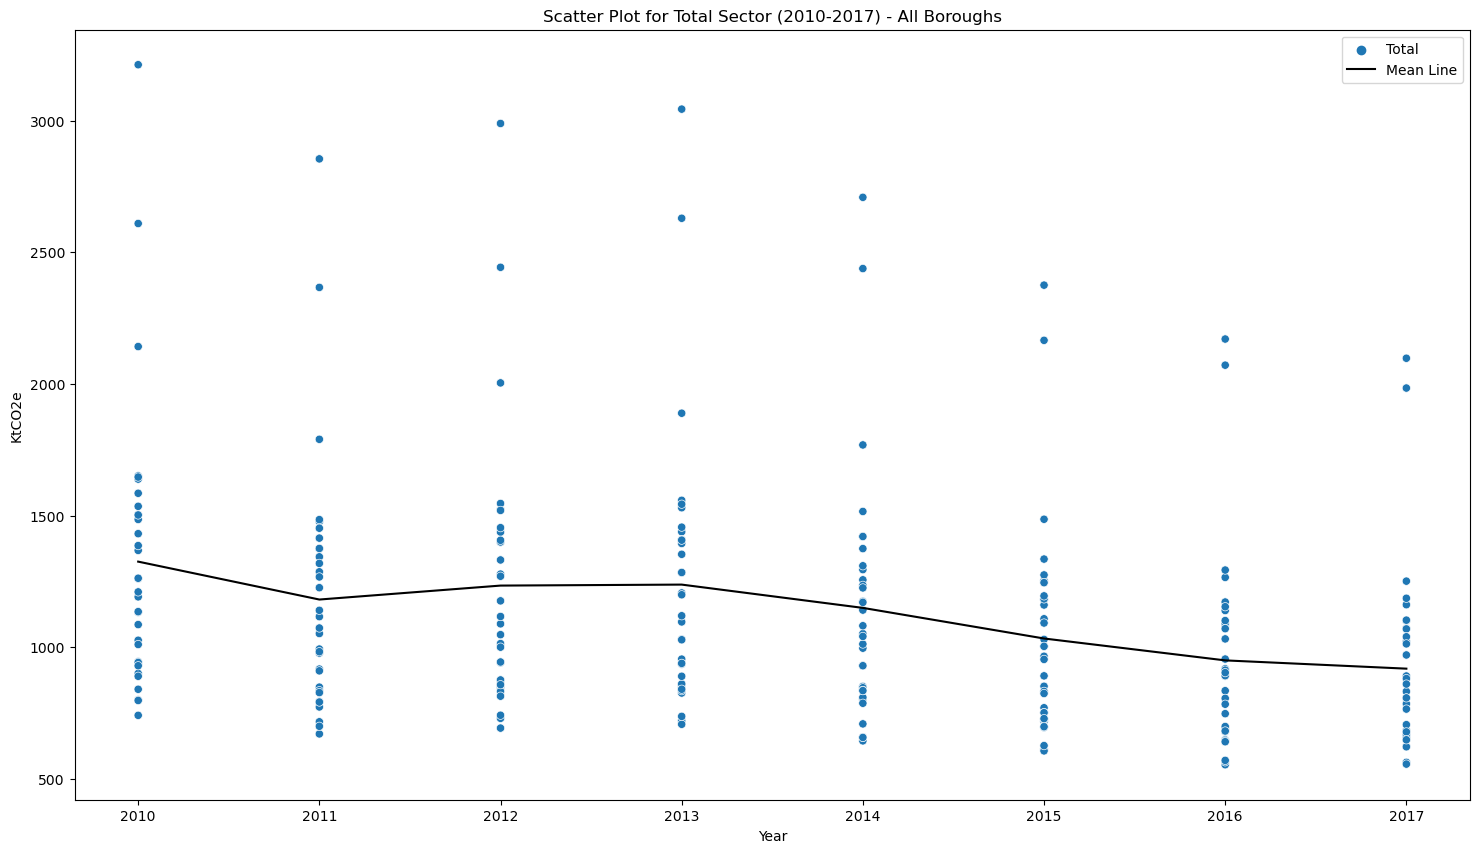

In [932]:
#Plotting for Total Sector (2010-2017) - All Boroughs
# Filter data for the relevant years and exclude London borough and 'Total' fuel type
filtered_data_total_boroughs_total = data_emissions_copy[    (data_emissions_copy['Borough'] != 'London')&(data_emissions_copy['Sector'] == 'Total')]

filtered_data_total_boroughs_total['KtCO2e'] = pd.to_numeric(filtered_data_total_boroughs_total['KtCO2e'], errors='coerce')

# Plot scatter plot for the 'Domestic' sector
plt.figure(figsize=(18, 10))
sns.scatterplot(x='LEGGI_Year', y='KtCO2e',hue='Fuel', data=filtered_data_total_boroughs_total)
                
# Calculate mean values for each year
mean_line = filtered_data_total_boroughs_total.groupby('LEGGI_Year')['KtCO2e'].mean().reset_index()

# Plot mean line for the entire graph
sns.lineplot(x='LEGGI_Year', y='KtCO2e', data=mean_line, color='black', label='Mean Line')

# Set plot title and axis labels
plt.title('Scatter Plot for Total Sector (2010-2017) - All Boroughs')
plt.xlabel('Year')
plt.ylabel('KtCO2e')
plt.show()

In [933]:
# Function to calculate z-scores
def z_score(data):
    return (data - np.mean(data)) / np.std(data)

# Calculate z-scores for each data point within its group (year) for the Total sector
filtered_data_total_boroughs_total['Z_Score'] = filtered_data_total_boroughs_total.groupby('LEGGI_Year')['KtCO2e'].transform(z_score)

# Set a threshold for z-score to identify outliers
z_score_threshold_total = 1.5 

# Identify outliers based on z-score for the Total sector
outliers_total = filtered_data_total_boroughs_total[np.abs(filtered_data_total_boroughs_total['Z_Score']) > z_score_threshold_total]


outliers_total


Borough  LEGGI_Year Sector   Fuel       KtCO2e   Z_Score
611      Hillingdon        2017  Total  Total  2097.508945  3.390011
627     Westminster        2017  Total  Total  1984.283036  3.064484
1241     Hillingdon        2016  Total  Total  2170.464015  3.358993
1257    Westminster        2016  Total  Total  2071.191608  3.085824
1871     Hillingdon        2015  Total  Total  2165.514599  2.897518
1887    Westminster        2015  Total  Total  2375.198732  3.433969
2501     Hillingdon        2014  Total  Total  2438.154066  2.855494
2517    Westminster        2014  Total  Total  2708.731602  3.454921
3131     Hillingdon        2013  Total  Total  2629.229908  2.770695
3147    Westminster        2013  Total  Total  3043.784452  3.596099
3761     Hillingdon        2012  Total  Total  2442.964832  2.494482
3774  Tower Hamlets        2012  Total  Total  2003.844633  1.588494
3777    Westminster        2012  Total  Total  2989.303775  3.621681
4391     Hillingdon        2011  Total  Total  2366.563002  2.578812
4407    Westminster        2011  Total  Total  2854.747754  3.640641
5021     Hillingdon        2010  Total  Total  2609.261706  2.478077
5034  Tower Hamlets        2010  Total  Total  2141.889857  1.576297
5037    Westminster        2010  Total  Total  3212.433061  3.641878

The total sector gives an overview of all 32 Boroughs. The trend from 2010 to 2017 is that we can see total co2 emission from all sectors is decreasing graduually and most boroughs have very close in terms of total co2 emissions in 2017. The Boroughs which seem to have the highest total emissions are Westminister, Tower Hamlets and Hillingdon

Part 3 Fuel type contribution

3.1 Domestic Sector

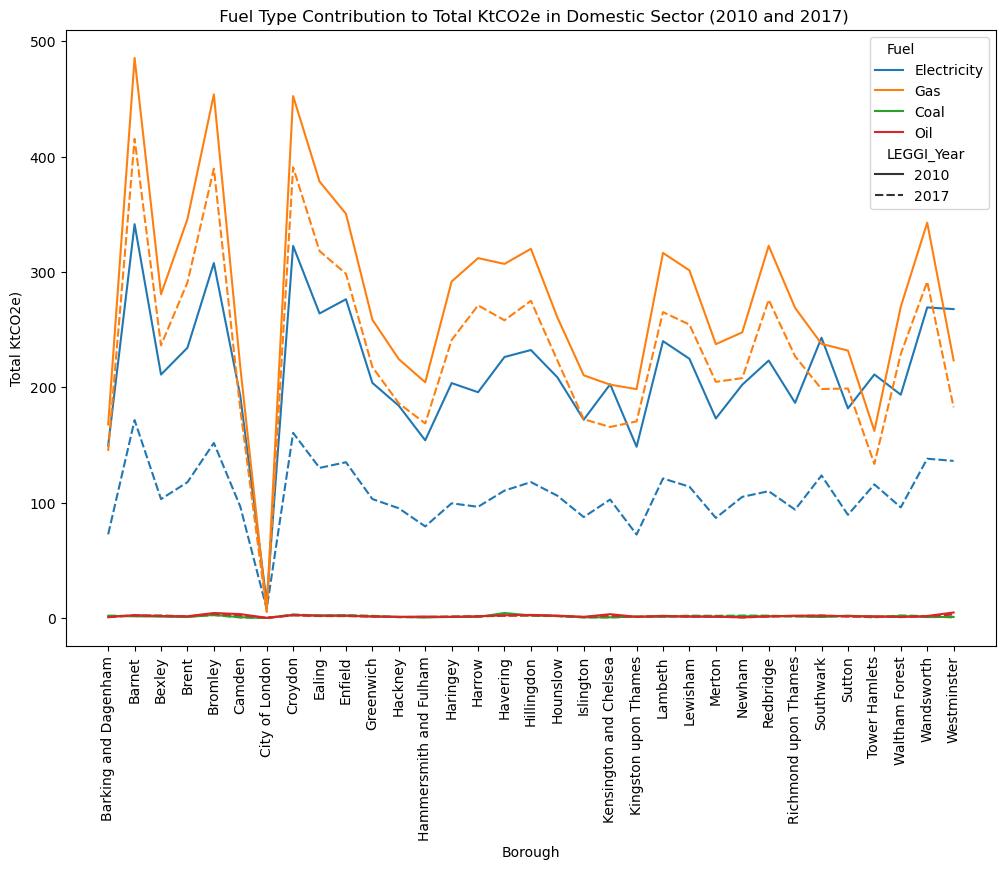

In [934]:
#Looking at the trend between 2010 and 2017 for domestic sector 
# Filter data for 2010 and 2017
filtered_data_domestic_boroughs_Nottotal_2010_2017 = data_emissions_copy[(data_emissions_copy['LEGGI_Year'].isin([2010, 2017])) & (data_emissions_copy['Sector'] == 'Domestic') & (data_emissions_copy['Borough'] != 'London') & (data_emissions_copy['Fuel'] != 'Total')]

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Set y-axis to logarithmic scale
#Reference style order
#Reference hue
sns.lineplot(x='Borough', y='KtCO2e', hue='Fuel', style='LEGGI_Year', style_order=[2010, 2017], data=filtered_data_domestic_boroughs_Nottotal_2010_2017)
plt.title(" Fuel Type Contribution to Total KtCO2e in Domestic Sector (2010 and 2017)")
plt.xlabel("Borough")
plt.ylabel("Total KtCO2e)")

# Rotate x-axis labels for better visibilitysince labels overlap
plt.xticks(rotation=90)

# Show the plot
plt.show()






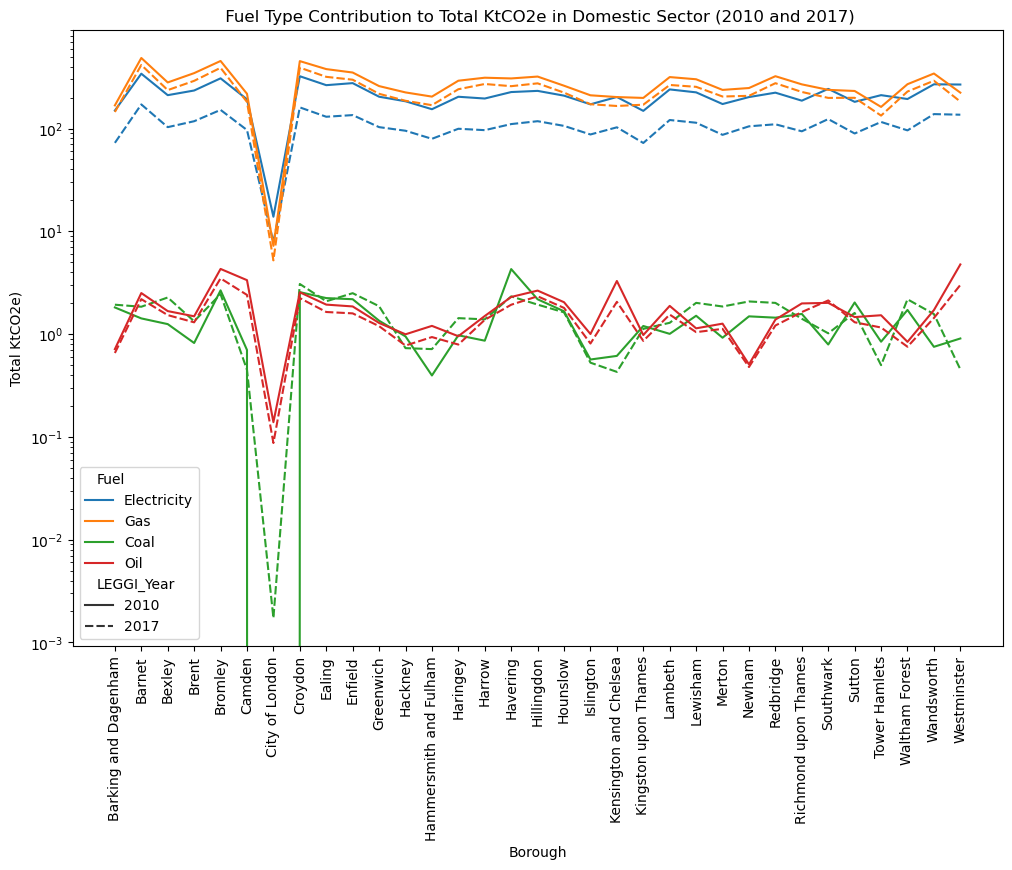

In [935]:
#Looking at the trend between 2010 and 2017 for domestic sector 
# Filter data for 2010 and 2017
filtered_data_domestic_boroughs_Nottotal_2010_2017 = data_emissions_copy[(data_emissions_copy['LEGGI_Year'].isin([2010, 2017])) & (data_emissions_copy['Sector'] == 'Domestic') & (data_emissions_copy['Borough'] != 'London') & (data_emissions_copy['Fuel'] != 'Total')]

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Set y-axis to logarithmic scale
#Reference style order
#Reference hue
ax = sns.lineplot(x='Borough', y='KtCO2e', hue='Fuel', style='LEGGI_Year', style_order=[2010, 2017], data=filtered_data_domestic_boroughs_Nottotal_2010_2017)
ax.set_yscale('log')
plt.title(" Fuel Type Contribution to Total KtCO2e in Domestic Sector (2010 and 2017)")
plt.xlabel("Borough")
plt.ylabel("Total KtCO2e)")

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Show the plot
plt.show()

The General trend is that total fuel contibutions have dropped since 2010, we can look at correlation to assess the correlation between each

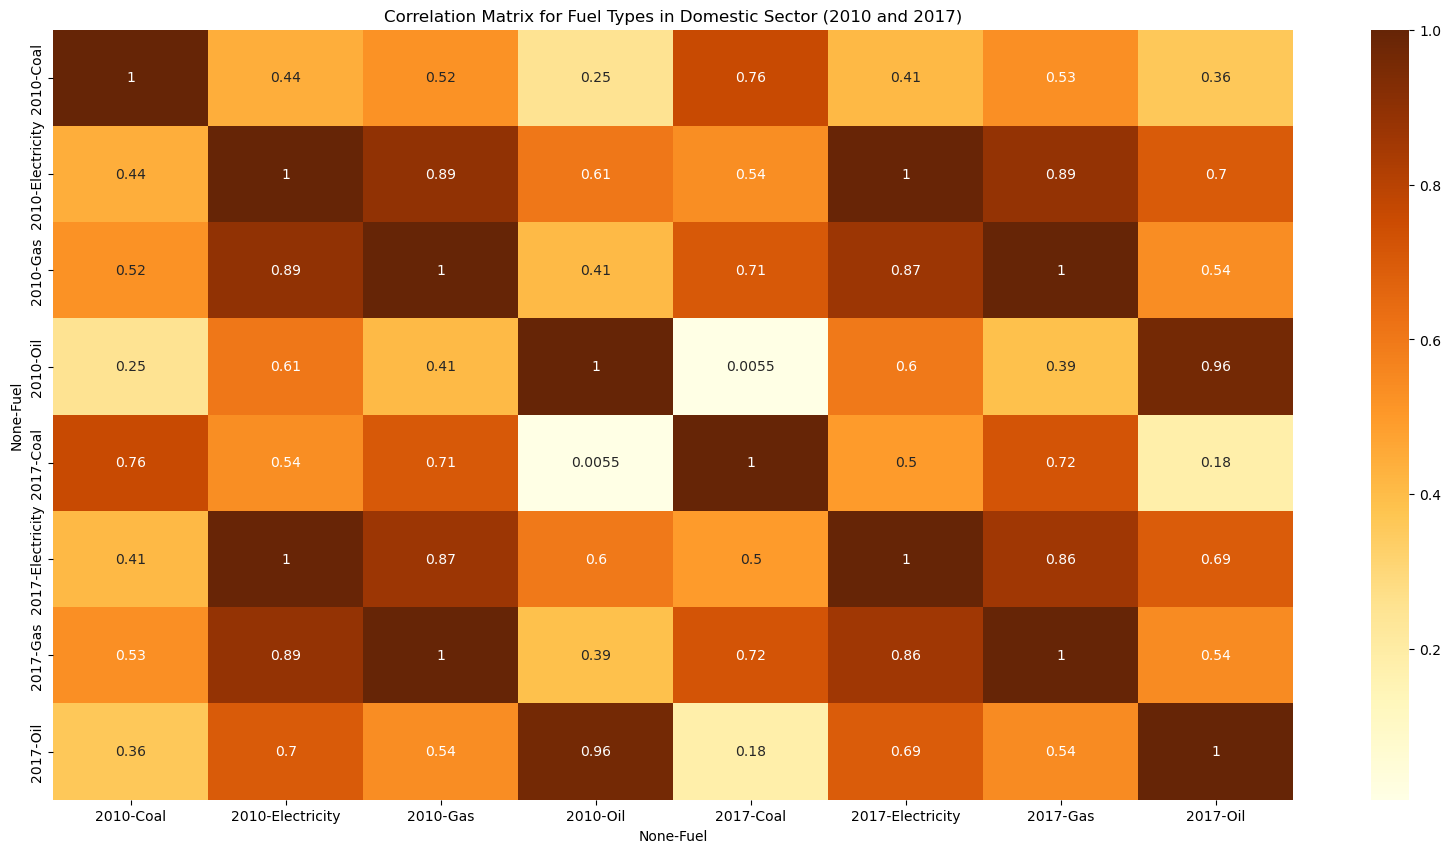

In [936]:
#*
#Correlation Matrix
#Reference: https://github.com/vighnesh32/Principles-of-Data-Science-Project/blob/main/project.ipynb

pivot_domestic_2010 = filtered_data_domestic_boroughs_Nottotal_2010.pivot_table(index='Borough', columns='Fuel', values='KtCO2e', aggfunc='sum')

# Pivot the DataFrame to have fuel types as columns for 2017
pivot_domestic_2017 = filtered_data_domestic_boroughs_Nottotal_2017.pivot_table(index='Borough', columns='Fuel', values='KtCO2e', aggfunc='sum')

# Concatenate the two DataFrames along a new axis (columns)
concatenated_data = pd.concat([pivot_domestic_2010, pivot_domestic_2017], axis=1, keys=['2010', '2017'])

# Calculate correlation matrix
correlation_matrix = concatenated_data.corr()

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(20, 10))

# Create a heatmap using seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='YlOrBr', fmt=".2g")

# Show the plot which also displays pearsons correlation
plt.title("Correlation Matrix for Fuel Types in Domestic Sector (2010 and 2017)")
plt.show()

Specific correlations which stand out are;
2010 oil and 2017 oil, and 2010 oil and 2017 coal

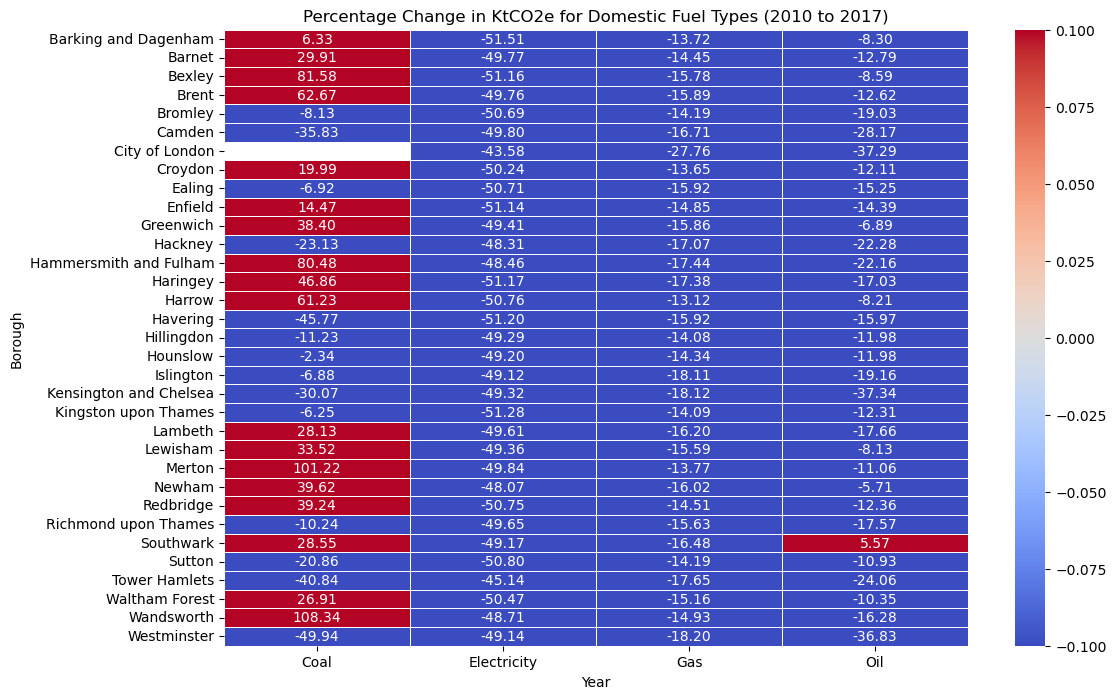

In [937]:
#Percentage change heatmap for domestic
domestic_table_data = filtered_data_domestic_boroughs_Nottotal_2010_2017.pivot_table(values='KtCO2e', index=['Borough', 'Fuel'], columns='LEGGI_Year', aggfunc='sum')

# Calculate percentage change
domestic_table_data['Percentage Change'] = ((domestic_table_data[2017] - domestic_table_data[2010]) / domestic_table_data[2010] * 100).round(2)


plt.figure(figsize=(12, 8))

# Create a heatmap using sns
sns.heatmap(domestic_table_data['Percentage Change'].unstack(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title("Percentage Change in KtCO2e for Domestic Fuel Types (2010 to 2017)")
plt.xlabel("Year")
plt.ylabel("Borough")


plt.show()










From the percentage change graph majority of the fuel types have decreased it seems that electricity has had the biggest decrease. Moreoeverusage of coal for domestic use seems to have increase. London City coal usage is almost neglible in 2010 it was reported 0 and in 2017 it was reported as 0.0017292, hence its an empty cell

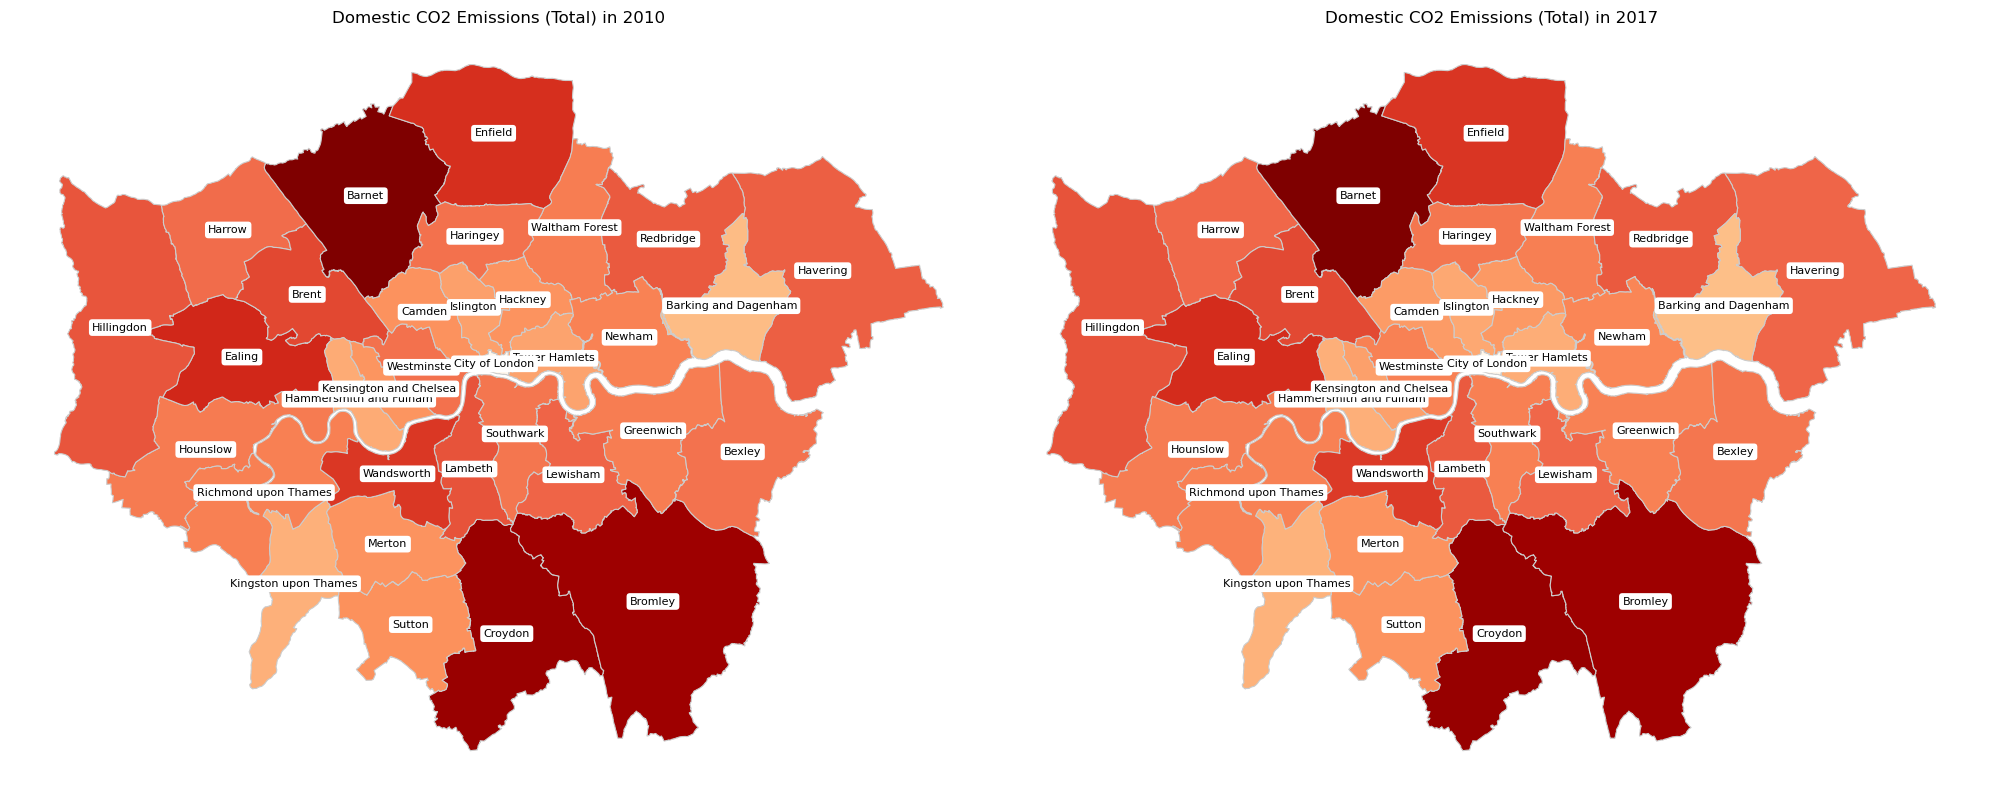

In [960]:
#Comparison on map
#Load the shapefile
#Reference: https://data.london.gov.uk/dataset/statistical-gis-boundary-files-london
fp = 'statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp'
map_df = gpd.read_file(fp)

# Filter CO2 emissions for the year 2010 and 'Domestic' sector
co2_2010_domestic = data_emissions_copy[(data_emissions_copy['LEGGI_Year'] == 2010) & (data_emissions_copy['Sector'] == 'Domestic') & (data_emissions_copy['Fuel'] == 'Total')]
#low to high
# Filter CO2 emissions for the year 2017 and 'Domestic' sector
co2_2017_domestic = data_emissions_copy[(data_emissions_copy['LEGGI_Year'] == 2017) & (data_emissions_copy['Sector'] == 'Domestic') & (data_emissions_copy['Fuel'] == 'Total')]

# Merge the 'Domestic' DataFrames with the GeoDataFrame for 2010 and 2017
merged_2010_domestic = map_df.merge(co2_2010_domestic, left_on='NAME', right_on='Borough', how='left')
merged_2017_domestic = map_df.merge(co2_2017_domestic, left_on='NAME', right_on='Borough', how='left')

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Plot 'Domestic' CO2 emissions for 2010
#Using ax[i] to plot different axis

axs[0].set_title('Domestic CO2 Emissions (Total) in 2010')
merged_2010_domestic.plot(column='KtCO2e', cmap='OrRd', linewidth=0.8, ax=axs[0], edgecolor='0.8', legend=False)
axs[0].set_axis_off()

# Annotate the map with borough names for 2010
for x, y, label in zip(merged_2010_domestic.geometry.centroid.x, merged_2010_domestic.geometry.centroid.y, merged_2010_domestic['NAME']):
    axs[0].text(x, y, label, fontsize=8, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

# Plot 'Domestic' CO2 emissions for 2017
axs[1].set_title('Domestic CO2 Emissions (Total) in 2017')
merged_2017_domestic.plot(column='KtCO2e', cmap='OrRd', linewidth=0.8, ax=axs[1], edgecolor='0.8', legend=False)
axs[1].set_axis_off()

# Annotate the map with borough names for 2017
for x, y, label in zip(merged_2017_domestic.geometry.centroid.x, merged_2017_domestic.geometry.centroid.y, merged_2017_domestic['NAME']):
    axs[1].text(x, y, label, fontsize=8, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

plt.tight_layout()
plt.show()

3.2 Industrial & Commercial

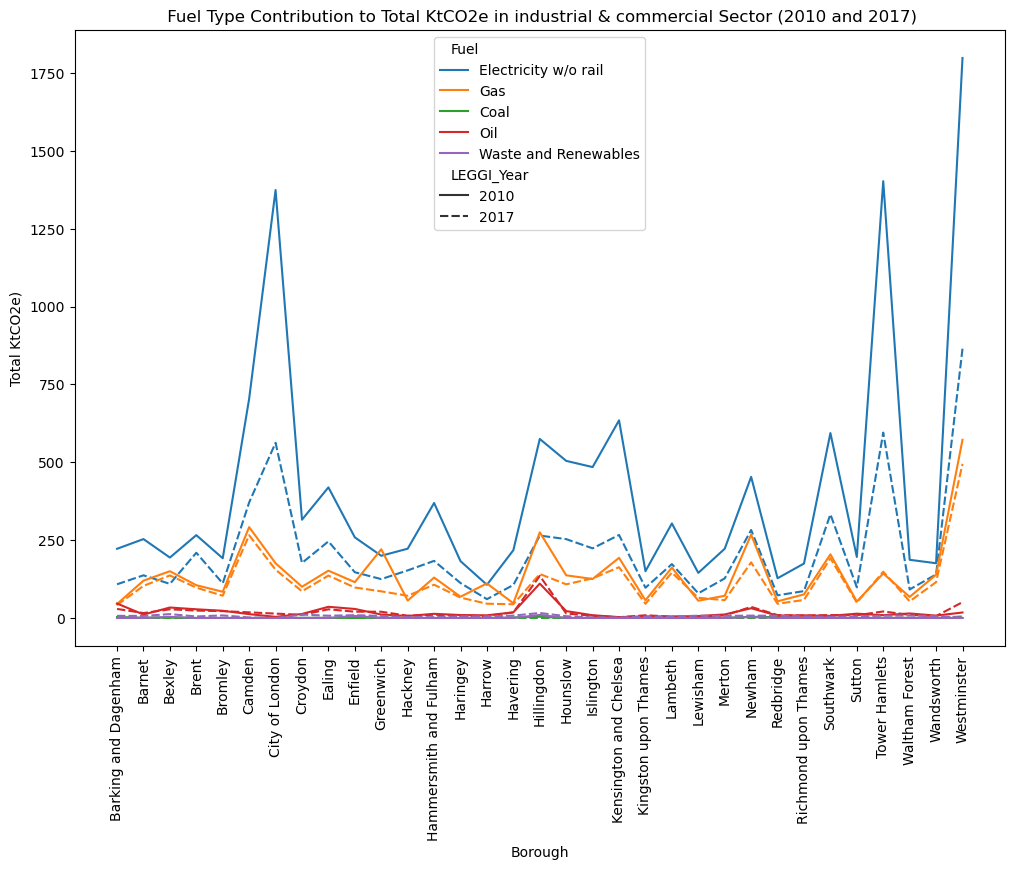

In [941]:
#Line graph
#Looking at the trend between 2010 and 2017 for industrial sector 
# Filter data for 2010 and 2017
filtered_data_industrial_commercial_boroughs_Nottotal_2010_2017 = data_emissions_copy[(data_emissions_copy['LEGGI_Year'].isin([2010, 2017])) & (data_emissions_copy['Sector'] == 'Industrial and Commercial') & (data_emissions_copy['Borough'] != 'London') & (data_emissions_copy['Fuel'] != 'Total')]

plt.figure(figsize=(12, 8))

sns.lineplot(x='Borough', y='KtCO2e', hue='Fuel', style='LEGGI_Year', style_order=[2010, 2017], data=filtered_data_industrial_commercial_boroughs_Nottotal_2010_2017)
plt.title(" Fuel Type Contribution to Total KtCO2e in industrial & commercial Sector (2010 and 2017)")
plt.xlabel("Borough")
plt.ylabel("Total KtCO2e)")

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

# Show the plot
plt.show()

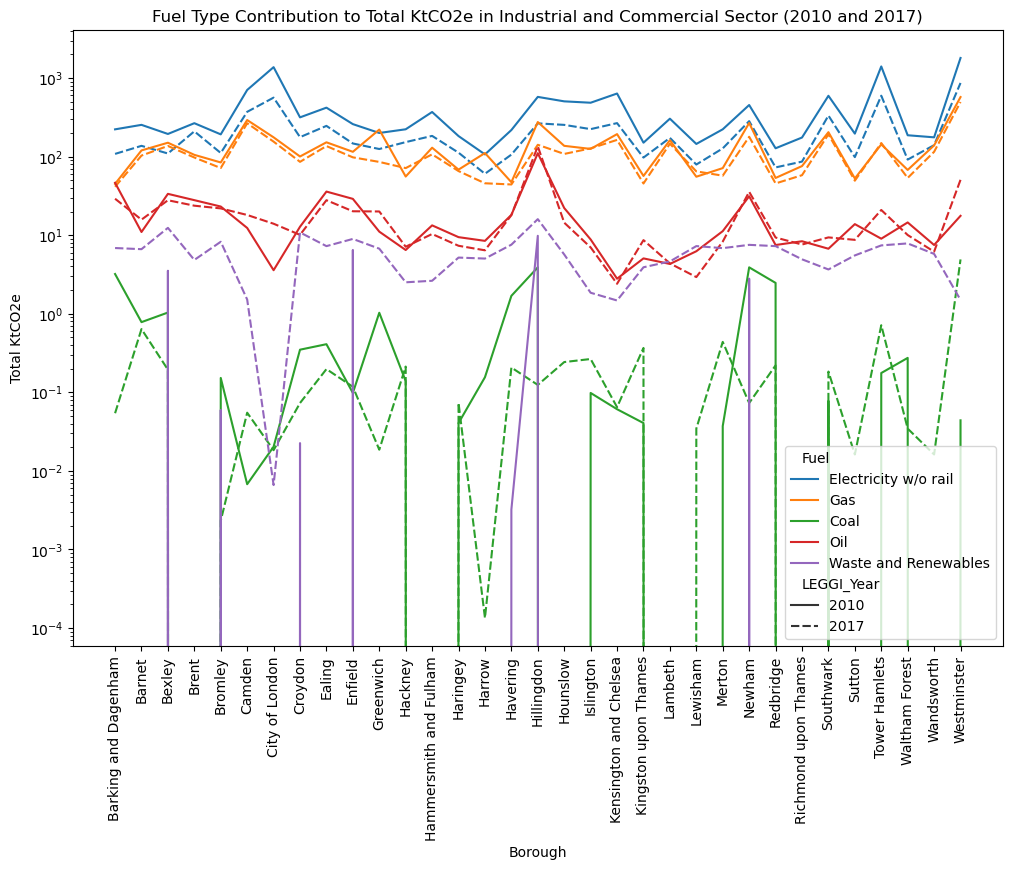

In [942]:
#Log line graph
# Filter data for 2010 and 2017, Industrial and Commercial sector
filtered_data_industrial_commercial_2010_2017 = data_emissions_copy[(data_emissions_copy['LEGGI_Year'].isin([2010, 2017])) & (data_emissions_copy['Sector'] == 'Industrial and Commercial') & (data_emissions_copy['Borough'] != 'London') & (data_emissions_copy['Fuel'] != 'Total')]

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Set y-axis to logarithmic scale
ax = sns.lineplot(x='Borough', y='KtCO2e', hue='Fuel', style='LEGGI_Year', style_order=[2010, 2017], data=filtered_data_industrial_commercial_2010_2017)
#Taking Logs
ax.set_yscale('log')
plt.title("Fuel Type Contribution to Total KtCO2e in Industrial and Commercial Sector (2010 and 2017)")
plt.xlabel("Borough")
plt.ylabel("Total KtCO2e")

# Rotate x-axis labels for better visibility
plt.xticks(rotation=90)

plt.show()



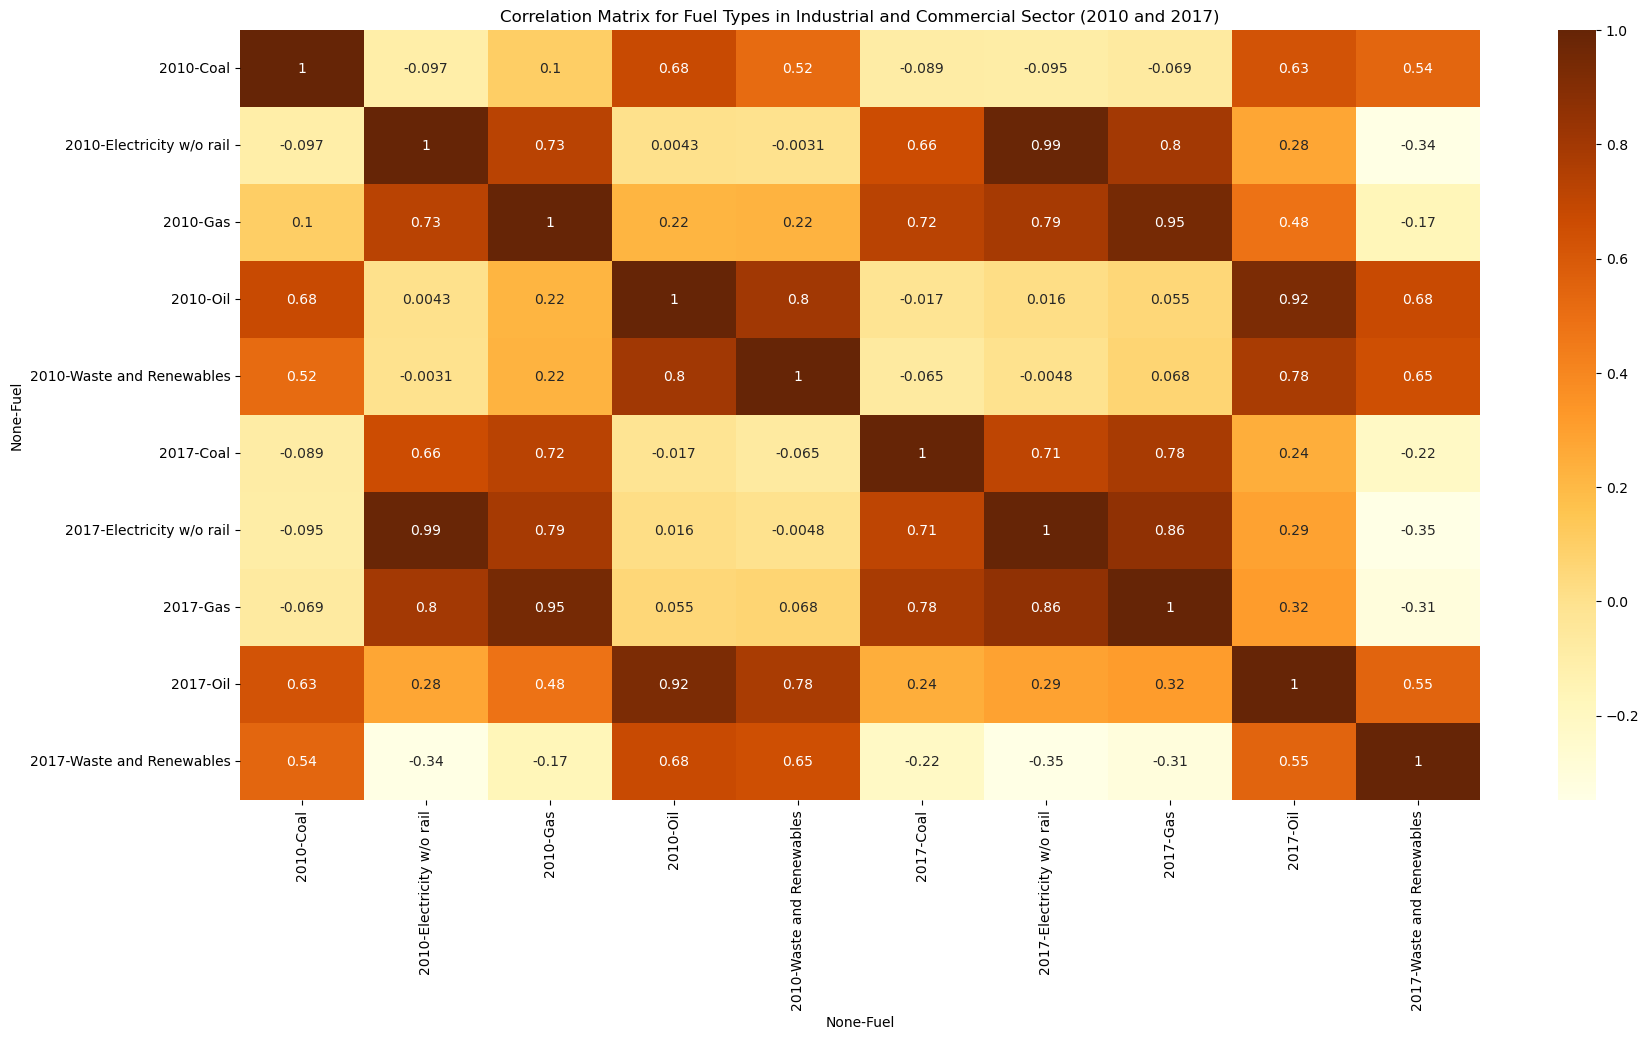

In [943]:
#Correlation matrix between 2010 and 2017
# Filter data for 2010, Industrial and Commercial sector, excluding 'London', and 'Fuel' not equal to 'Total'
filtered_data_industrial_commercial_boroughs_Nottotal_2010 = data_emissions_copy[(data_emissions_copy['LEGGI_Year'] == 2010) & (data_emissions_copy['Sector'] == 'Industrial and Commercial') & (data_emissions_copy['Borough'] != 'London') &  (data_emissions_copy['Fuel'] != 'Total')]

# Pivot the DataFrame to have fuel types as columns for 2010 in the Industrial and Commercial sector
pivot_industrial_commercial_2010 = filtered_data_industrial_commercial_boroughs_Nottotal_2010.pivot_table(index='Borough', columns='Fuel', values='KtCO2e', aggfunc='sum')

# Filter data for 2017, Industrial and Commercial sector, excluding 'London', and 'Fuel' not equal to 'Total'
filtered_data_industrial_commercial_boroughs_Nottotal_2017 = data_emissions_copy[(data_emissions_copy['LEGGI_Year'] == 2017) & (data_emissions_copy['Sector'] == 'Industrial and Commercial') & (data_emissions_copy['Borough'] != 'London') & (data_emissions_copy['Fuel'] != 'Total')]

# Pivot the DataFrame to have fuel types as columns for 2017 in the Industrial and Commercial sector
pivot_industrial_commercial_2017 = filtered_data_industrial_commercial_boroughs_Nottotal_2017.pivot_table(index='Borough', columns='Fuel', values='KtCO2e', aggfunc='sum')

# Concatenate the two DataFrames along a new axis
concatenated_industrial_commercial_data = pd.concat([pivot_industrial_commercial_2010, pivot_industrial_commercial_2017],axis=1,keys=['2010', '2017'])

# Calculate correlation matrix for the Industrial and Commercial sector
correlation_matrix_industrial_commercial = concatenated_industrial_commercial_data.corr()


fig, ax = plt.subplots(figsize=(20, 10))

#heatmap using seaborn for the Industrial and Commercial sector
sns.heatmap(correlation_matrix_industrial_commercial, annot=True, cmap='YlOrBr', fmt=".2g")


plt.title("Correlation Matrix for Fuel Types in Industrial and Commercial Sector (2010 and 2017)")
plt.show()


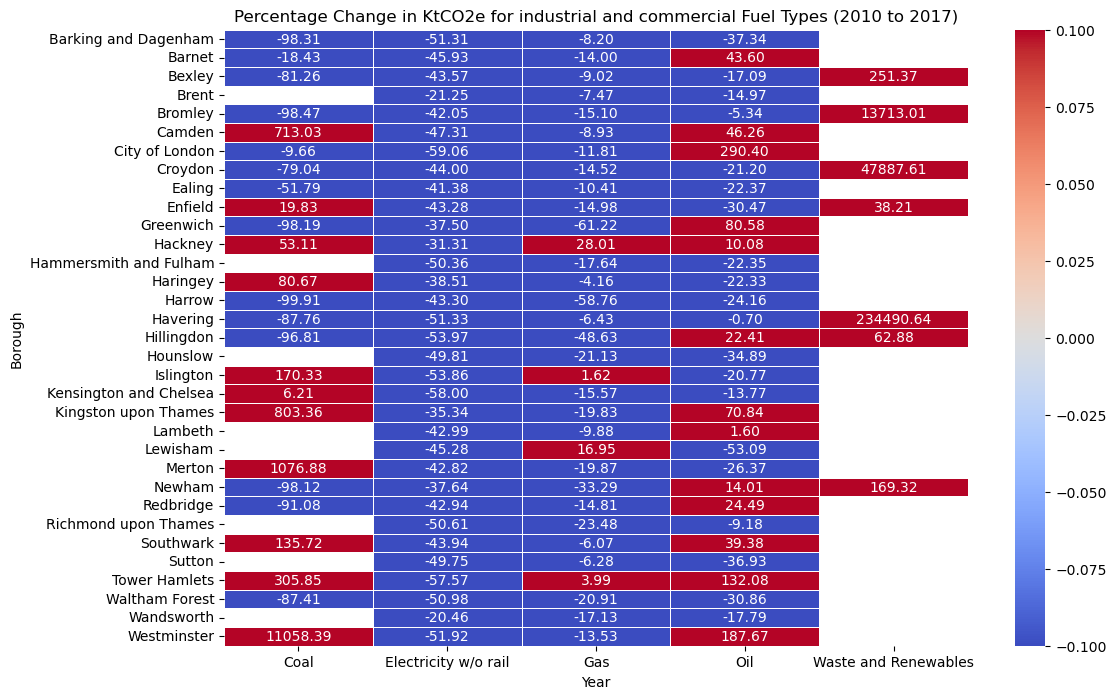

In [962]:
#Percentage change heatmap
# Create a pivot table for the Transport sector
table_data_industrial_commercial = filtered_data_industrial_commercial_boroughs_Nottotal_2010_2017.pivot_table( values='KtCO2e', index=['Borough', 'Fuel'], columns='LEGGI_Year', aggfunc='sum')

# Calculate percentage change
table_data_industrial_commercial['Percentage Change'] = ((table_data_industrial_commercial[2017] - table_data_industrial_commercial[2010]) / table_data_industrial_commercial[2010] * 100)

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a heatmap for the Transport sector
sns.heatmap(table_data_industrial_commercial['Percentage Change'].unstack(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title("Percentage Change in KtCO2e for industrial and commercial Fuel Types (2010 to 2017)")
plt.xlabel("Year")
plt.ylabel("Borough")

# Show the plot
plt.show()


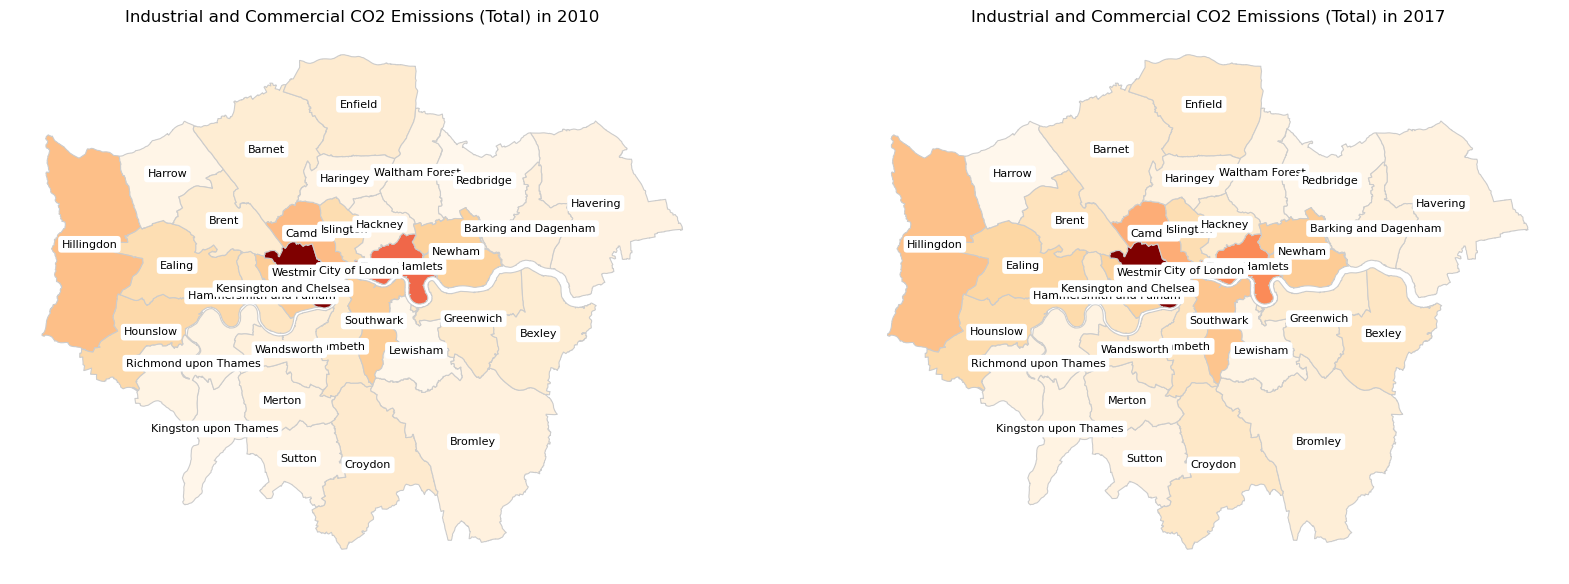

In [963]:
#Chlorpleth map
# Filter CO2 emissions for the year 2010 and 'Industrial and Commercial' sector
co2_2010_industrial_commercial = data_emissions_copy[(data_emissions_copy['LEGGI_Year'] == 2010) & (data_emissions_copy['Sector'] == 'Industrial and Commercial') & (data_emissions_copy['Fuel'] == 'Total')]

# Filter CO2 emissions for the year 2017 and 'Industrial and Commercial' sector
co2_2017_industrial_commercial = data_emissions_copy[(data_emissions_copy['LEGGI_Year'] == 2017) & (data_emissions_copy['Sector'] == 'Industrial and Commercial') & (data_emissions_copy['Fuel'] == 'Total')]


merged_2010_industrial_commercial = map_df.merge(co2_2010_industrial_commercial, left_on='NAME', right_on='Borough', how='left')
merged_2017_industrial_commercial = map_df.merge(co2_2017_industrial_commercial, left_on='NAME', right_on='Borough', how='left')

# Plot subplots
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Plot 'Industrial and Commercial' CO2 emissions for 2010
axs[0].set_title('Industrial and Commercial CO2 Emissions (Total) in 2010')
merged_2010_industrial_commercial.plot(column='KtCO2e', cmap='OrRd', linewidth=0.8, ax=axs[0], edgecolor='0.8', legend=False)
axs[0].set_axis_off()

# 2010 map annotations
for x, y, label in zip(merged_2010_industrial_commercial.geometry.centroid.x, merged_2010_industrial_commercial.geometry.centroid.y, merged_2010_industrial_commercial['NAME']):
    axs[0].text(x, y, label, fontsize=8, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

# Plot 'Industrial and Commercial' CO2 emissions for 2017
axs[1].set_title('Industrial and Commercial CO2 Emissions (Total) in 2017')
merged_2017_industrial_commercial.plot(column='KtCO2e', cmap='OrRd', linewidth=0.8, ax=axs[1], edgecolor='0.8', legend=False)
axs[1].set_axis_off()

# 2017 map annotations
for x, y, label in zip(merged_2017_industrial_commercial.geometry.centroid.x, merged_2017_industrial_commercial.geometry.centroid.y, merged_2017_industrial_commercial['NAME']):
    axs[1].text(x, y, label, fontsize=8, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))


plt.show()


3.3 Transport

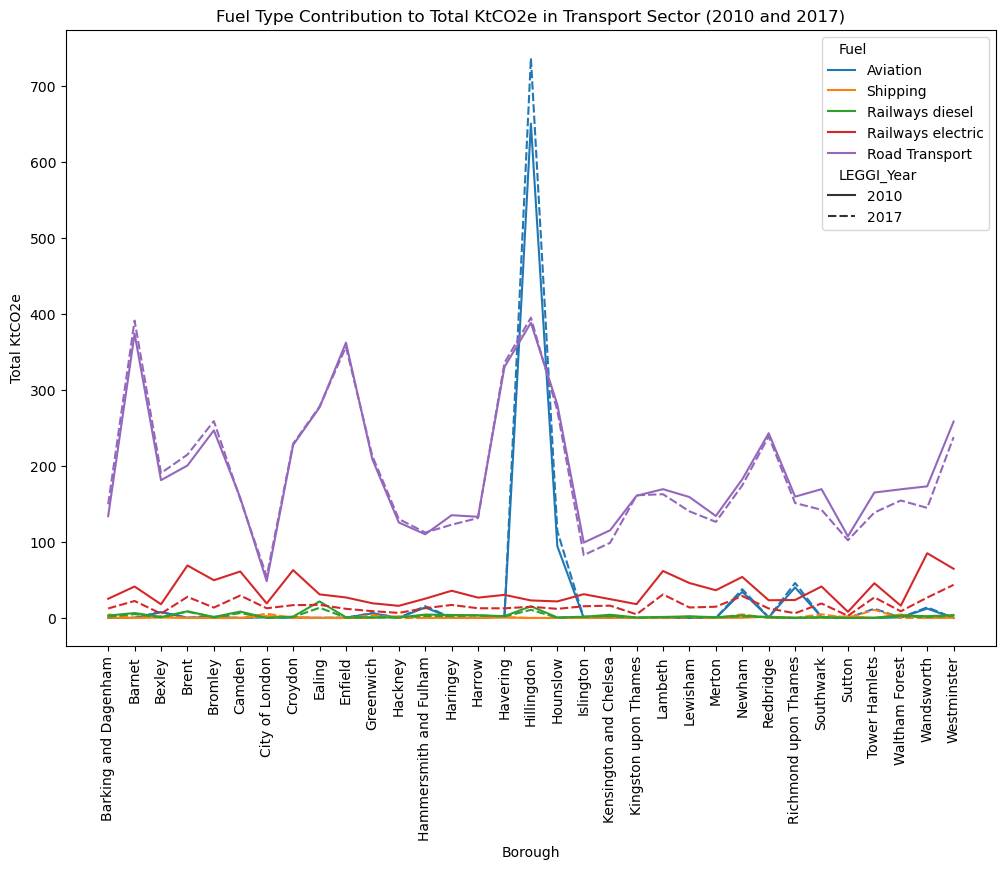

In [948]:
#Line graph showing fuel contribution
# Filter data for 2010 and 2017, Transport sector, excluding 'London', and 'Fuel' not equal to 'Total'
filtered_data_transport_boroughs_Nottotal_2010_2017 = data_emissions_copy[(data_emissions_copy['LEGGI_Year'].isin([2010, 2017])) & (data_emissions_copy['Sector'] == 'Transport') & (data_emissions_copy['Borough'] != 'London') & (data_emissions_copy['Fuel'] != 'Total')]
plt.figure(figsize=(12, 8))
sns.lineplot(x='Borough', y='KtCO2e', hue='Fuel', style='LEGGI_Year', style_order=[2010, 2017], data=filtered_data_transport_boroughs_Nottotal_2010_2017)
plt.title("Fuel Type Contribution to Total KtCO2e in Transport Sector (2010 and 2017)")
plt.xlabel("Borough")
plt.ylabel("Total KtCO2e")
plt.xticks(rotation=90)
plt.show()


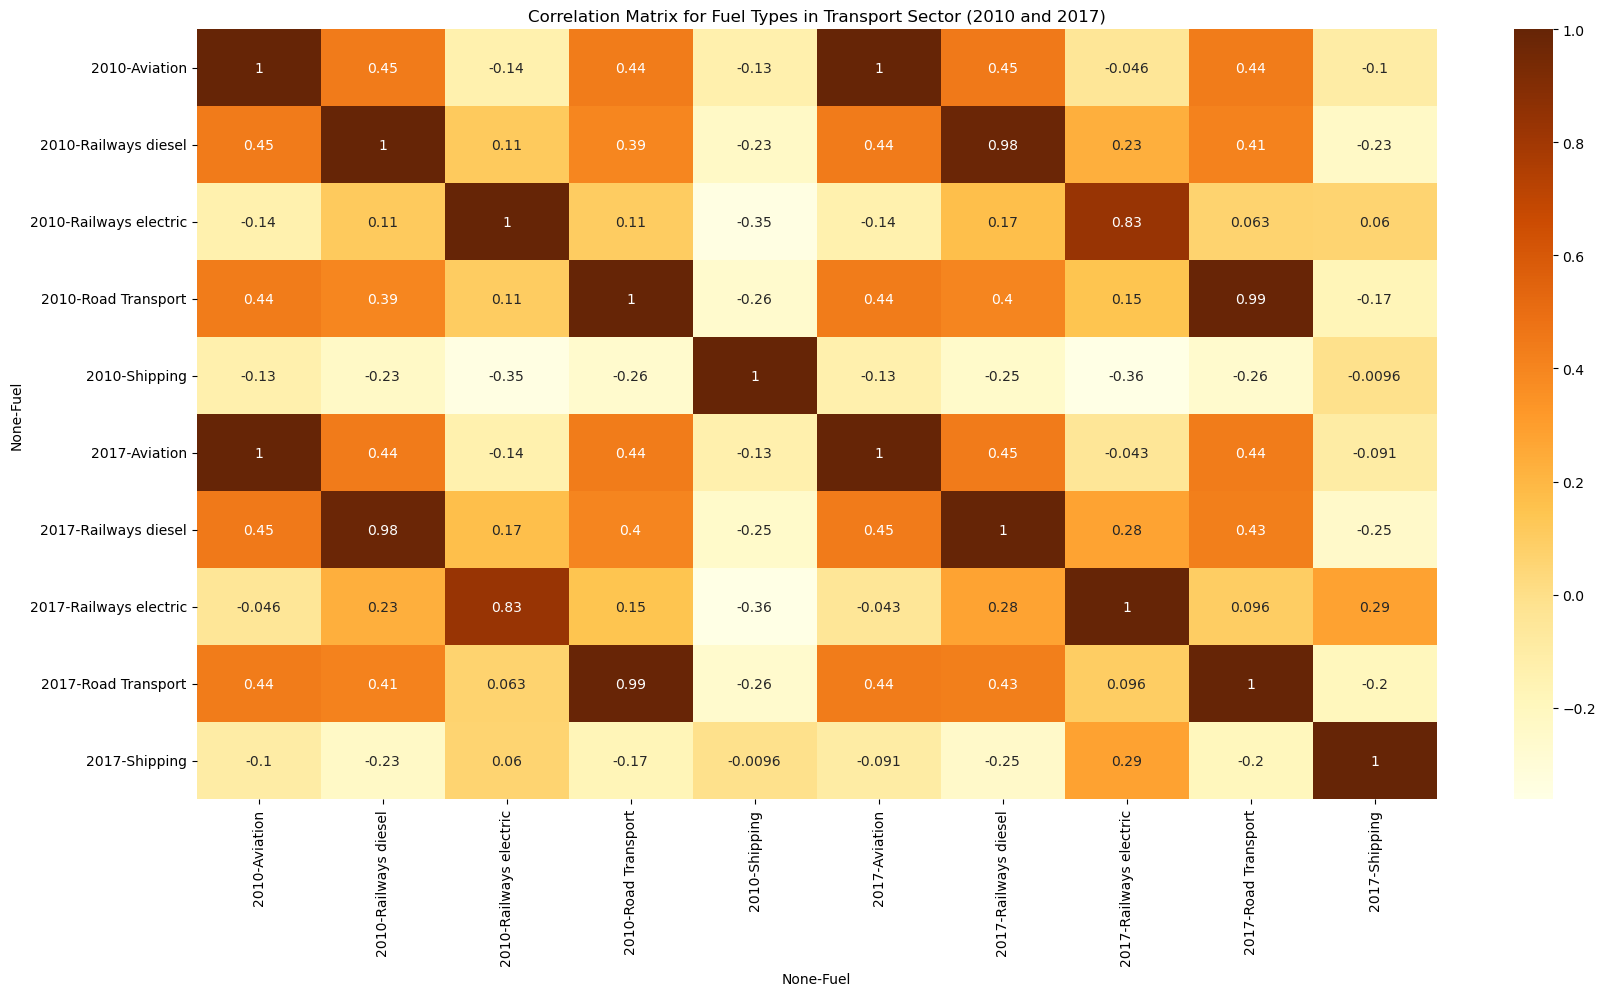

In [949]:
#Correlation matrix between 2010 and 2017

filtered_data_transport_boroughs_Nottotal_2010 = data_emissions_copy[(data_emissions_copy['LEGGI_Year'] == 2010) & (data_emissions_copy['Sector'] == 'Transport') & (data_emissions_copy['Borough'] != 'London') & (data_emissions_copy['Fuel'] != 'Total')]

# Filter data for 2017, Transport sector, excluding 'London', and 'Fuel' not equal to 'Total'
filtered_data_transport_boroughs_Nottotal_2017 = data_emissions_copy[(data_emissions_copy['LEGGI_Year'] == 2017) & (data_emissions_copy['Sector'] == 'Transport') & (data_emissions_copy['Borough'] != 'London') & (data_emissions_copy['Fuel'] != 'Total')]

# Pivot the DataFrame to have fuel types as columns for 2010 in the Transport sector
pivot_transport_2010 = filtered_data_transport_boroughs_Nottotal_2010.pivot_table(index='Borough', columns='Fuel', values='KtCO2e', aggfunc='sum')

# Pivot the DataFrame to have fuel types as columns for 2017 in the Transport sector
pivot_transport_2017 = filtered_data_transport_boroughs_Nottotal_2017.pivot_table(index='Borough', columns='Fuel', values='KtCO2e', aggfunc='sum')

# Concatenate the two DataFrames along a new axis (columns)
concatenated_transport_data = pd.concat([pivot_transport_2010, pivot_transport_2017], axis=1, keys=['2010', '2017'])

# Calculate correlation matrix for the Transport sector
correlation_matrix_transport = concatenated_transport_data.corr()

fig, ax = plt.subplots(figsize=(20, 10))

# Create a heatmap using seaborn for the Transport sector
sns.heatmap(correlation_matrix_transport, annot=True, cmap='YlOrBr', fmt=".2g")


plt.title("Correlation Matrix for Fuel Types in Transport Sector (2010 and 2017)")
plt.show()

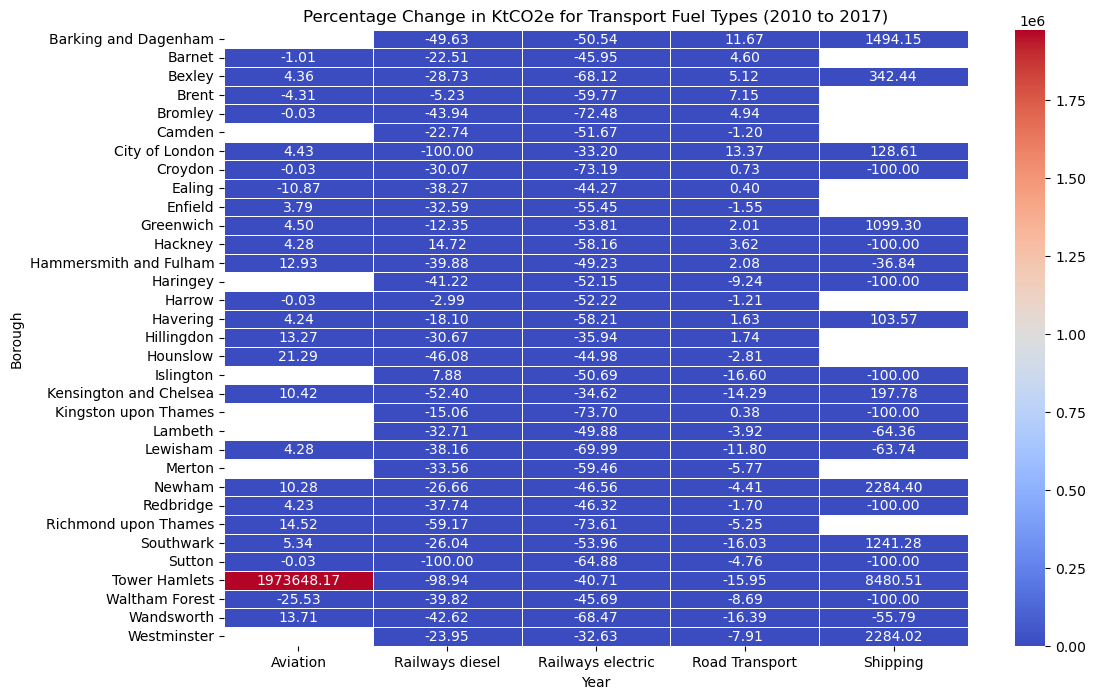

In [950]:
#Calculating Percentage changes
#filtering nessesary columns
table_data_transport = filtered_data_transport_boroughs_Nottotal_2010_2017.pivot_table(values='KtCO2e', index=['Borough', 'Fuel'], columns='LEGGI_Year', aggfunc='sum')

# Calculate percentage change
table_data_transport['Percentage Change'] = ((table_data_transport[2017] - table_data_transport[2010]) / table_data_transport[2010] * 100).round(2)


plt.figure(figsize=(12, 8))

# Create a heatmap for the Transport sector
sns.heatmap(table_data_transport['Percentage Change'].unstack(),annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)

plt.title("Percentage Change in KtCO2e for Transport Fuel Types (2010 to 2017)")
plt.xlabel("Year")
plt.ylabel("Borough")


plt.show()


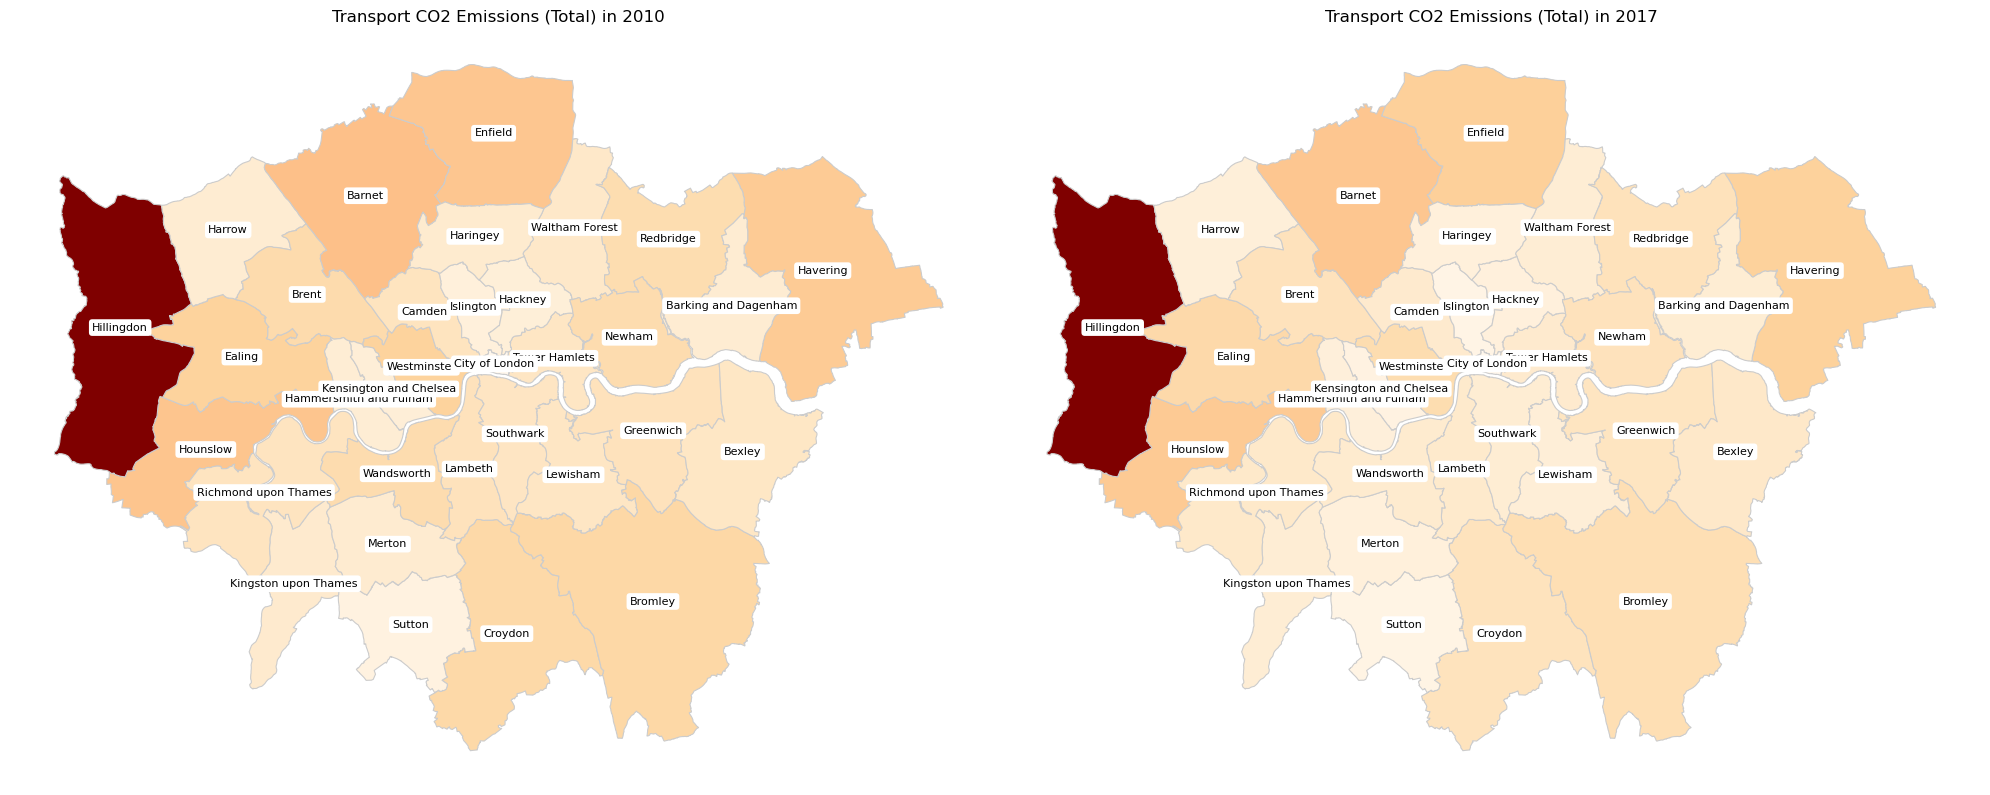

In [953]:
#Chloropleth map for emissions transport sector
# Filter CO2 emissions for the year 2010 and 'Transport' sector
co2_2010_transport = data_emissions_copy[(data_emissions_copy['LEGGI_Year'] == 2010) & (data_emissions_copy['Sector'] == 'Transport') & (data_emissions_copy['Fuel'] == 'Total')]

# Filter CO2 emissions for the year 2017 and 'Transport' sector
co2_2017_transport = data_emissions_copy[(data_emissions_copy['LEGGI_Year'] == 2017) & (data_emissions_copy['Sector'] == 'Transport') & (data_emissions_copy['Fuel'] == 'Total')]

# Merge the 'Transport' DataFrames with the GeoDataFrame for 2010 and 2017
merged_2010_transport = map_df.merge(co2_2010_transport, left_on='NAME', right_on='Borough', how='left')
merged_2017_transport = map_df.merge(co2_2017_transport, left_on='NAME', right_on='Borough', how='left')

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(20, 8))

# Plot 'Transport' CO2 emissions for 2010
axs[0].set_title('Transport CO2 Emissions (Total) in 2010')
merged_2010_transport.plot(column='KtCO2e', cmap='OrRd', linewidth=0.8, ax=axs[0], edgecolor='0.8', legend=False)
axs[0].set_axis_off()

# Annotate the map with borough names for 2010
for x, y, label in zip(merged_2010_transport.geometry.centroid.x, merged_2010_transport.geometry.centroid.y, merged_2010_transport['NAME']):
    axs[0].text(x, y, label, fontsize=8, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

# Plot 'Transport' CO2 emissions for 2017
axs[1].set_title('Transport CO2 Emissions (Total) in 2017')
merged_2017_transport.plot(column='KtCO2e', cmap='OrRd', linewidth=0.8, ax=axs[1], edgecolor='0.8', legend=False)
axs[1].set_axis_off()

# Annotate the map with borough names for 2017
for x, y, label in zip(merged_2017_transport.geometry.centroid.x, merged_2017_transport.geometry.centroid.y, merged_2017_transport['NAME']):
    axs[1].text(x, y, label, fontsize=8, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

plt.tight_layout()
plt.show()


4. Analytical Question

4.1 Domestic Vs Industrial 

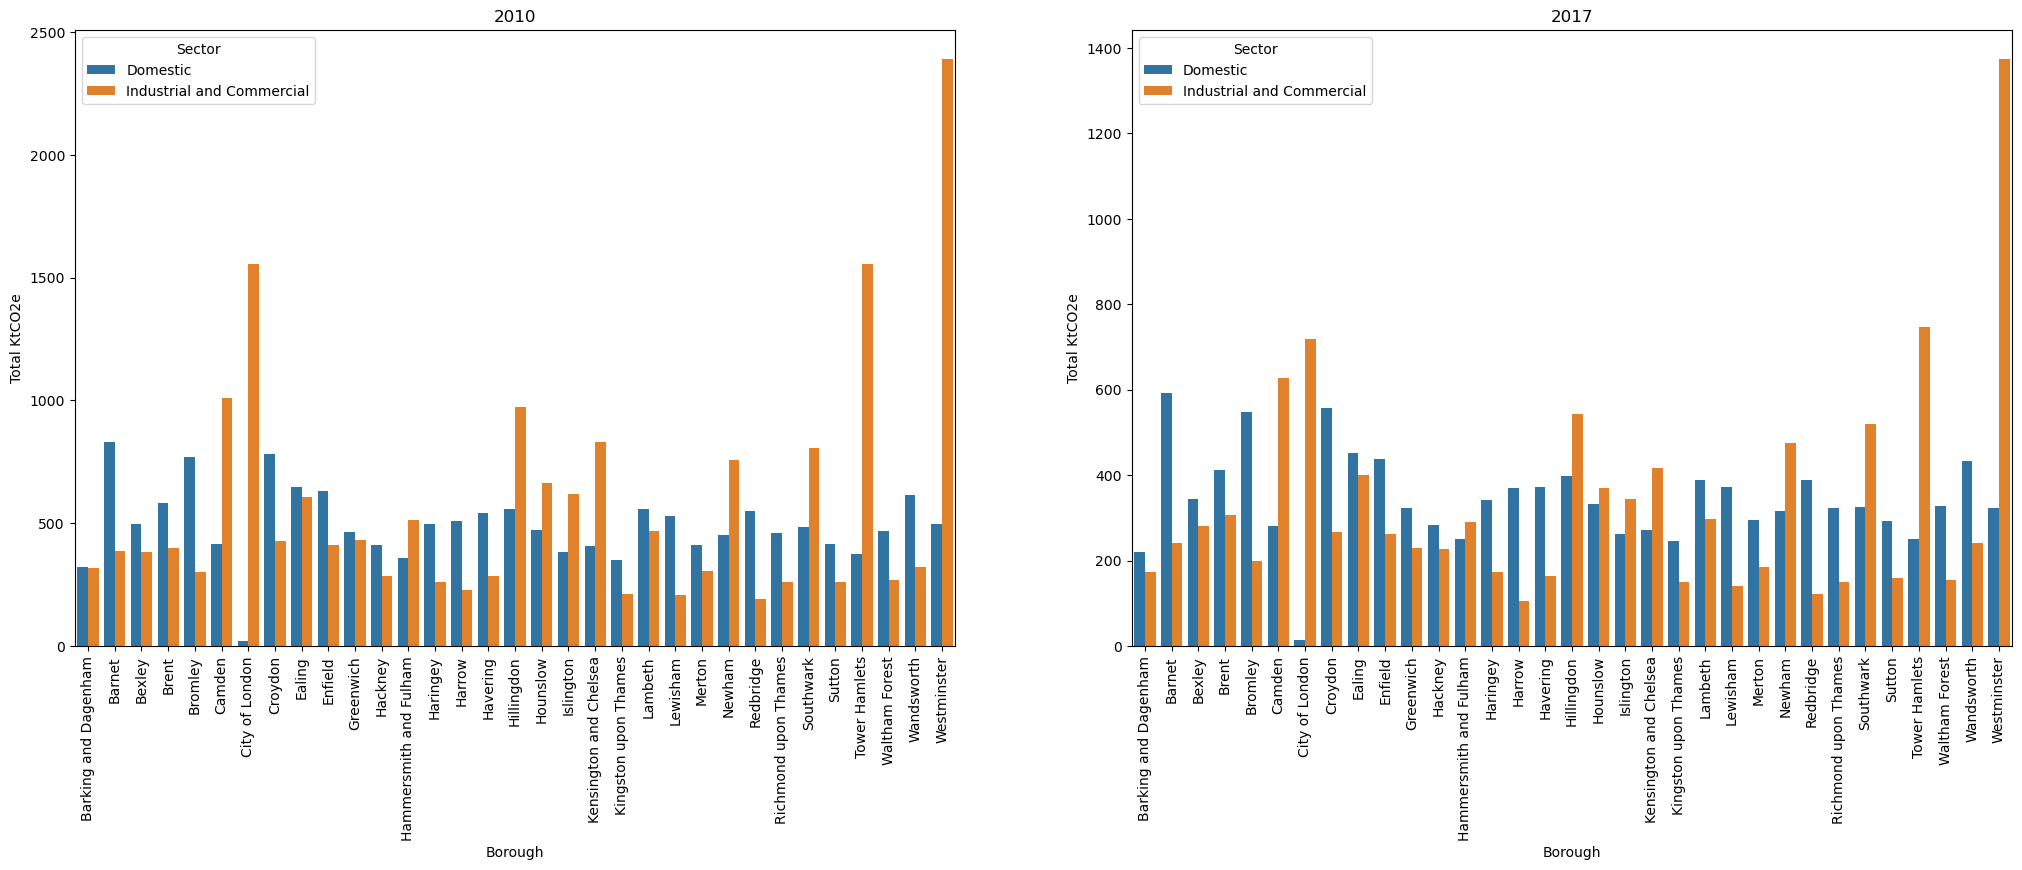

In [954]:
#Bar plot comparison of sector between 2010 and 2017
filtered_data = data_emissions_population[(data_emissions_population['LEGGI_Year'].isin([2010, 2017])) &(data_emissions_population['Sector'].isin(['Domestic', 'Industrial and Commercial'])) &(data_emissions_population['Borough'] != 'London') &(data_emissions_population['Fuel'] == 'Total')]

# Grouping variables needed
grouped_data = filtered_data.groupby(['Borough', 'LEGGI_Year', 'Sector'])['KtCO2e'].sum().reset_index()

# Create separate bar plots for 2010 and 2017
plt.figure(figsize=(25, 8))

# Bar plot for 2010
#Subplots
plt.subplot(1, 2, 1)
sns.barplot(x='Borough', y='KtCO2e', hue='Sector', data=grouped_data[grouped_data['LEGGI_Year'] == 2010], ci=None)
plt.title('2010')
plt.xlabel('Borough')
plt.ylabel('Total KtCO2e')
plt.legend(title='Sector')
plt.xticks(rotation=90)

# Bar plot for 2017
plt.subplot(1, 2, 2)
sns.barplot(x='Borough', y='KtCO2e', hue='Sector', data=grouped_data[grouped_data['LEGGI_Year'] == 2017], ci=None)
plt.title('2017')
plt.xlabel('Borough')
plt.ylabel('Total KtCO2e')
plt.legend(title='Sector')
plt.xticks(rotation=90)

plt.show()



4.2 Domestic Vs Transport

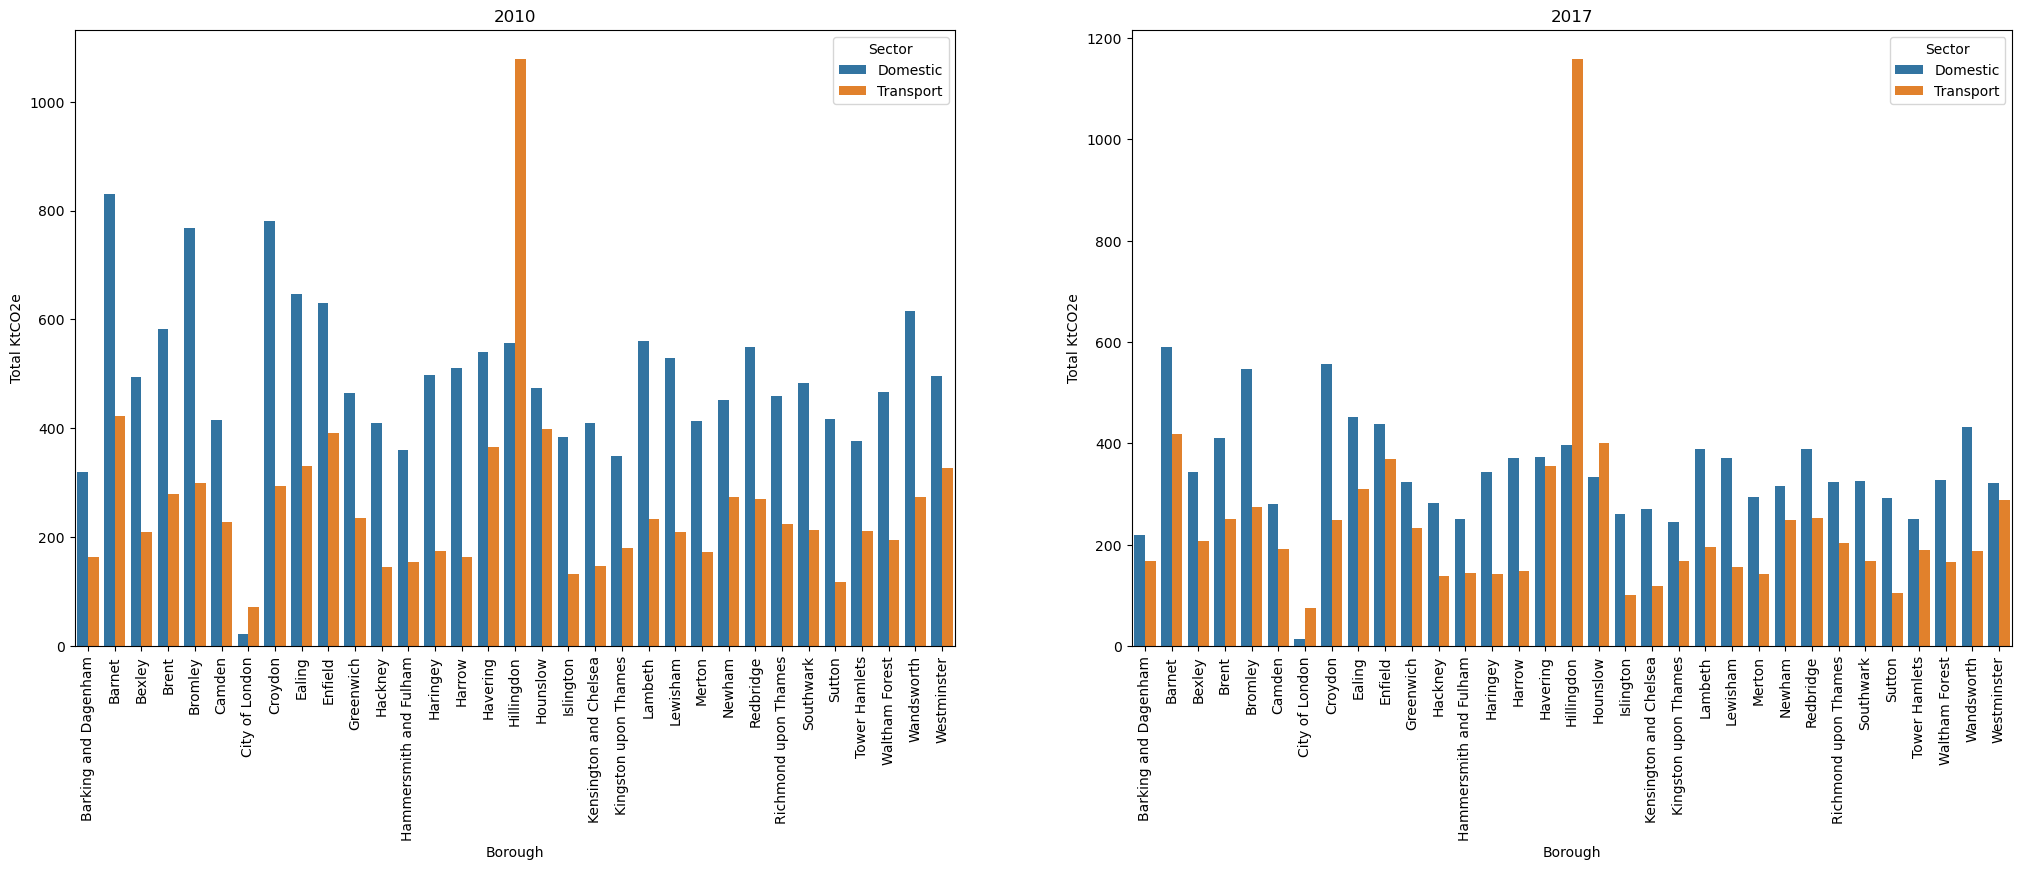

In [955]:
#Bar plot comparison of sector
filtered_data = data_emissions_population[(data_emissions_population['LEGGI_Year'].isin([2010, 2017])) &(data_emissions_population['Sector'].isin(['Domestic', 'Transport'])) &(data_emissions_population['Borough'] != 'London') &(data_emissions_population['Fuel'] == 'Total')]

#Creating grouped data using variables required
grouped_data = filtered_data.groupby(['Borough', 'LEGGI_Year', 'Sector'])['KtCO2e'].sum().reset_index()

plt.figure(figsize=(25, 8))

# Bar plot for 2010
#Creating subplots
plt.subplot(1, 2, 1)
sns.barplot(x='Borough', y='KtCO2e', hue='Sector', data=grouped_data[grouped_data['LEGGI_Year'] == 2010], ci=None)
plt.title('2010')
plt.xlabel('Borough')
plt.ylabel('Total KtCO2e')
plt.legend(title='Sector')
plt.xticks(rotation=90)

# Bar plot for 2017
plt.subplot(1, 2, 2)
sns.barplot(x='Borough', y='KtCO2e', hue='Sector', data=grouped_data[grouped_data['LEGGI_Year'] == 2017], ci=None)
plt.title('2017')
plt.xlabel('Borough')
plt.ylabel('Total KtCO2e')
plt.legend(title='Sector')
plt.xticks(rotation=90)
plt.show()

4.3 Population vs Co2

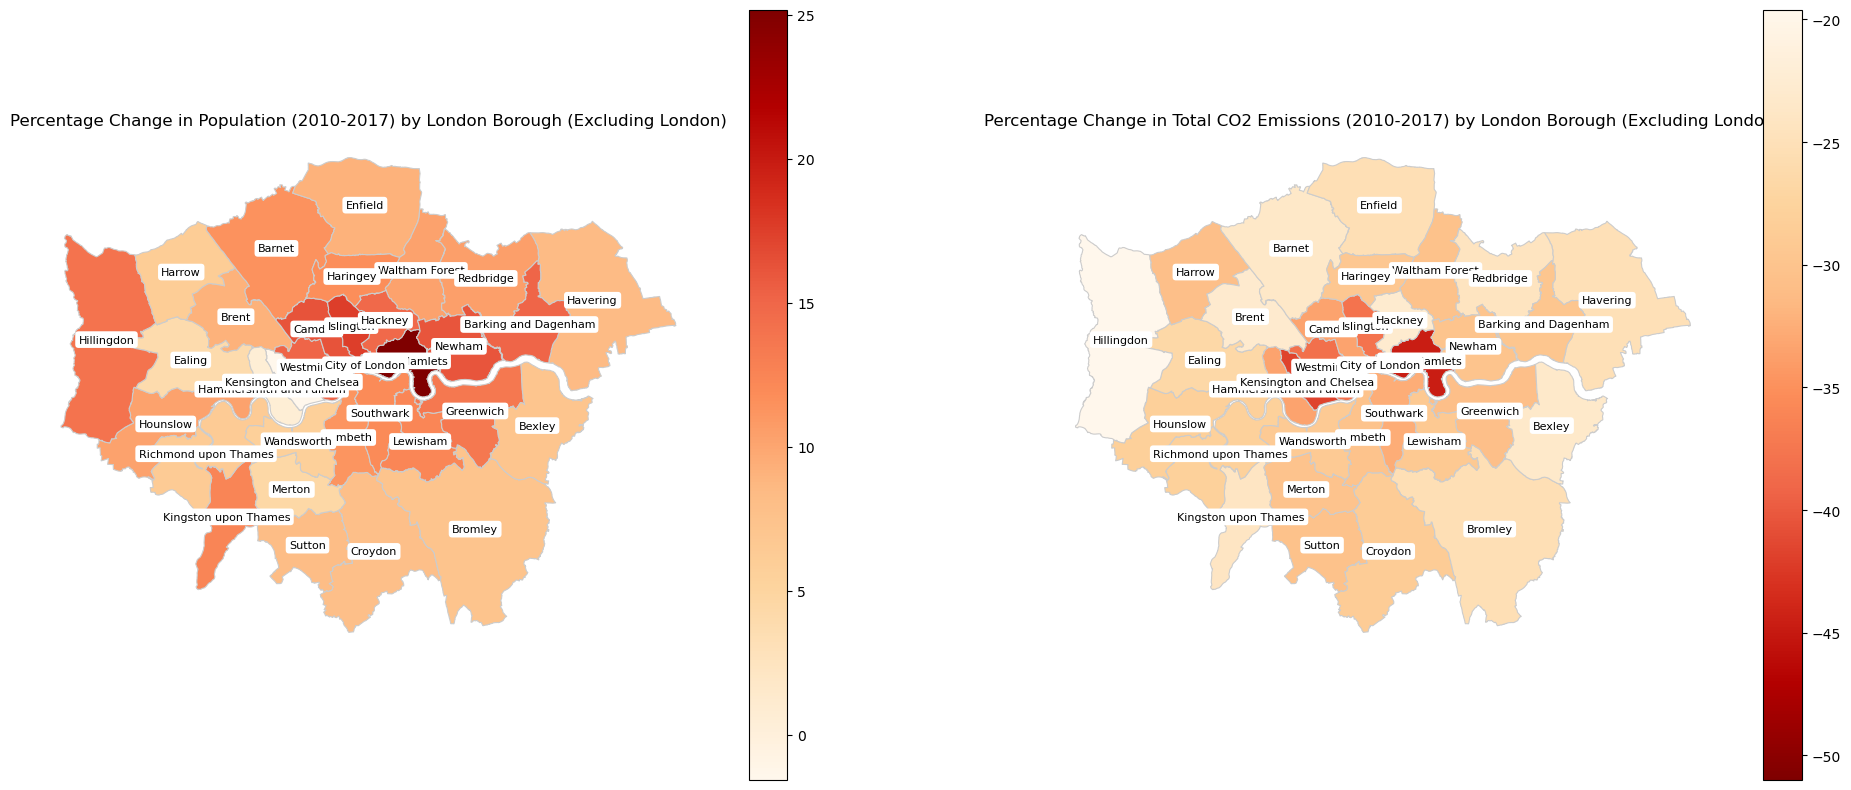

In [965]:
#Percentage change chloropleth map
# Exclude 'London' borough and filter for 'Total' sector
filtered_data = data_emissions_population[
    (data_emissions_population['Borough'] != 'London') & 
    (data_emissions_population['Sector'] == 'Total') &
    (data_emissions_population['LEGGI_Year'].isin([2010, 2017]))
]

# Create pivot tables for percentage change
pivot_population = filtered_data.pivot_table(
    index=['Borough'],
    columns='LEGGI_Year',
    values='Population',
    aggfunc='sum'
)

pivot_emissions = filtered_data.pivot_table(
    index=['Borough'],
    columns='LEGGI_Year',
    values='KtCO2e',
    aggfunc='sum'
)

# Calculate the percentage change for population
pivot_population['Percentage_Change_Population'] = (
    (pivot_population[2017] - pivot_population[2010]) / pivot_population[2010]
) * 100

# Calculate the percentage change for total emissions
pivot_emissions['Percentage_Change_Emissions'] = (
    (pivot_emissions[2017] - pivot_emissions[2010]) / pivot_emissions[2010]
) * 100

# Load the shapefile for London boroughs
fp = 'statistical-gis-boundaries-london/ESRI/London_Borough_Excluding_MHW.shp'
boroughs_shapefile = gpd.read_file(fp)

# Merge the GeoDataFrame with the filtered data
merged_population = boroughs_shapefile.merge(pivot_population, left_on='NAME', right_index=True, how='left')
merged_emissions = boroughs_shapefile.merge(pivot_emissions, left_on='NAME', right_index=True, how='left')


fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# Plotting the choropleth map for Percentage Change in Population
ax1 = merged_population.plot(column='Percentage_Change_Population', cmap='OrRd', linewidth=0.8, edgecolor='0.8', legend=True, ax=axes[0])
ax1.set_title('Percentage Change in Population (2010-2017) by London Borough (Excluding London)')
ax1.set_axis_off()
for x, y, label in zip(merged_population.geometry.centroid.x, merged_population.geometry.centroid.y, merged_population['NAME']):
    ax1.text(x, y, label, fontsize=8, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

# Plotting the choropleth map for Percentage Change in Total Emissions
ax2 = merged_emissions.plot(column='Percentage_Change_Emissions', cmap='OrRd_r', linewidth=0.8, edgecolor='0.8', legend=True, ax=axes[1])
ax2.set_title('Percentage Change in Total CO2 Emissions (2010-2017) by London Borough (Excluding London)')
ax2.set_axis_off()
for x, y, label in zip(merged_emissions.geometry.centroid.x, merged_emissions.geometry.centroid.y, merged_emissions['NAME']):
    ax2.text(x, y, label, fontsize=8, ha='center', va='center', bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.3'))

plt.show()

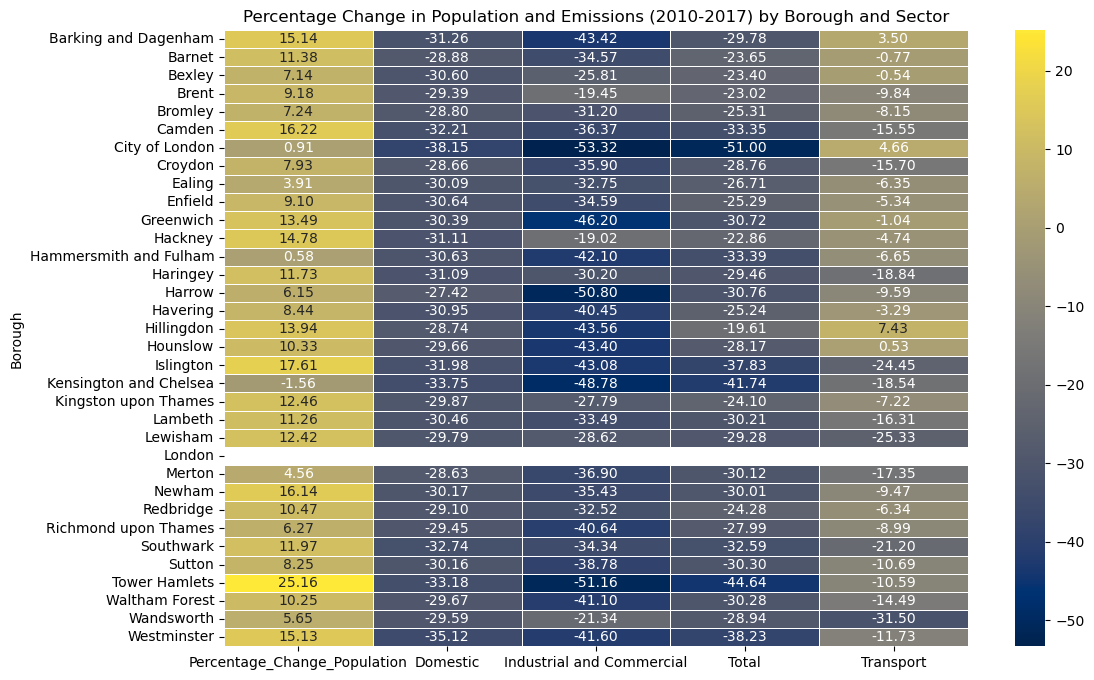

In [961]:
#Plotting heatmap of percentage change per sector
# Filter data for the years 2010 and 2017 and where 'Fuel' is 'Total'
data_population_change = data_emissions_population[(data_emissions_population['LEGGI_Year'].isin([2010, 2017])) & (data_emissions_population['Fuel'] == 'Total')]

# Create a pivot table for population change
pivot_population_change = data_population_change.pivot_table(index='Borough', columns='LEGGI_Year',values='Population',aggfunc='sum')

# Calculate the percentage change for population
pivot_population_change['Percentage_Change_Population'] = ((pivot_population_change[2017] - pivot_population_change[2010]) / pivot_population_change[2010]) * 100

# Create a pivot table for emissions change by sector
pivot_emissions_change = data_emissions_population.pivot_table(index=['Borough', 'Sector'],columns='LEGGI_Year', values='KtCO2e',aggfunc='sum')

# Calculating percentage change 
pivot_emissions_change['Percentage_Change_Emissions'] = ((pivot_emissions_change[2017] - pivot_emissions_change[2010]) / pivot_emissions_change[2010]) * 100

# Specify the sectors to plot based on the unique values in the 'Sector' column
sectors_to_plot = unique_sectors

# Filter data for specific sectors
filtered_emissions_change = pivot_emissions_change[pivot_emissions_change.index.get_level_values('Sector').isin(sectors_to_plot)]


filtered_emissions_change = filtered_emissions_change.unstack(level='Sector')

# Combine the population and emissions DataFrames
combined_data = pd.concat([pivot_population_change[['Percentage_Change_Population']], filtered_emissions_change['Percentage_Change_Emissions']], axis=1)

# Create a heatmap table using seaborn
plt.figure(figsize=(12, 8))
sns.heatmap(combined_data,annot=True,cmap='cividis',fmt='.2f',linewidths=.5)
plt.title('Percentage Change in Population and Emissions (2010-2017) by Borough and Sector')
plt.show()


Predictions

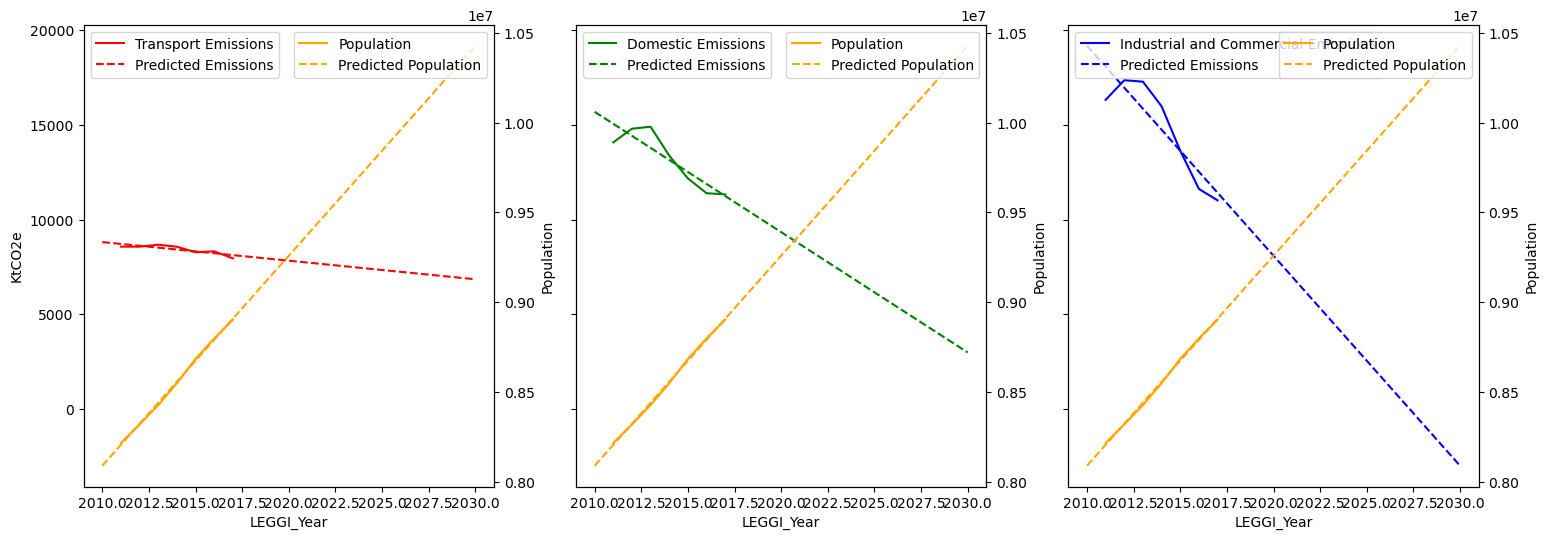

In [966]:
#Regression
#Table the sectors for for loop 
#Refernce: https://stackoverflow.com/questions/74905764/in-python-is-there-a-way-to-use-a-for-loop-to-perform-a-linear-regression-multi
sectors = ['Transport', 'Domestic', 'Industrial and Commercial']
colors = ['red', 'green', 'blue']

# Create subplots for each sector side by side
#Reference: https://stackoverflow.com/questions/50439431/difference-between-sharey-row-and-sharey-true
fig, axes = plt.subplots(nrows=1, ncols=len(sectors), figsize=(18, 6),sharey=True)

# Loop through each sector
for i, (sector, color) in enumerate(zip(sectors, colors)):
    # Plotting line graph for the sector with assigned color - Emissions
    sns.lineplot(x='LEGGI_Year',y='KtCO2e', data=filtered_data_london_sectors_2010_2017[filtered_data_london_sectors_2010_2017['Sector'] == sector],label=f'{sector} Emissions',ax=axes[i],color=color  )

    # Create a second y-axis to plot population data - Emissions
    ax2 = axes[i].twinx()
    sns.lineplot(x='LEGGI_Year', y='Population', data=filtered_data_london_sectors_2010_2017, label='Population', color='orange', ax=ax2)

    # Train the linear regression model for Emissions 
    X_emissions = filtered_data_london_sectors_2010_2017[filtered_data_london_sectors_2010_2017['Sector'] == sector][['LEGGI_Year']]
    y_emissions = filtered_data_london_sectors_2010_2017[filtered_data_london_sectors_2010_2017['Sector'] == sector]['KtCO2e']
    model_emissions = LinearRegression()
    #Reference:https://realpython.com/linear-regression-in-python/
    model_emissions.fit(X_emissions, y_emissions)

    # Predict emissions for future years
    future_years = pd.DataFrame({'LEGGI_Year': range(2010, 2031)})
    future_predictions_emissions = model_emissions.predict(future_years[['LEGGI_Year']])

    # Plot the regression line for emissions
    axes[i].plot(future_years['LEGGI_Year'], future_predictions_emissions, linestyle='dashed', label='Predicted Emissions', color=color)


    axes[i].legend(loc='upper left')

    # Train the linear regression model for Population
    X_population = filtered_data_london_sectors_2010_2017[filtered_data_london_sectors_2010_2017['Sector'] == sector][['LEGGI_Year']]
    y_population = filtered_data_london_sectors_2010_2017[filtered_data_london_sectors_2010_2017['Sector'] == sector]['Population']
    model_population = LinearRegression()
    model_population.fit(X_population, y_population)

    # Predict population for future years
    future_predictions_population = model_population.predict(future_years[['LEGGI_Year']])

    # Plot the regression line for population
    ax2.plot(future_years['LEGGI_Year'], future_predictions_population, linestyle='dashed', label='Predicted Population', color='orange')
    ax2.legend(loc='upper right')

plt.show()



